# ST10204902 PDAN8412 POE Part 1
## Nicholas Christopher Meyer

It is highly recommend that you run this notebook based on the repo available via OneDrive TODO here

This POE Part 1 explores a corpus from Victorian Era authors (Gungor, 2018). A Gdelt database was queried for the following characteristics: English language authors with at least 5 books available that were written in the 19th century (Gungor, 2018). 50 authors were selected but this work focuses on the training subsection of the dataset containing only 45 authors (Gungor, 2018). Each book was scanned using OCR and a removal of 500 head and tail words were removed in order to prevent author identification through attribution or publishing details (Gungor, 2018). The top 10 000 words from the texts were selected and all other words were removed from the text whilst keeping grammatically correct sentences (Gungor, 2018). Each book is split into fragments of 1 000 words each (Gungor, 2018).

The objective of this notebook is to train a Long-term Short-term Recursive Neural Network to identify authors based on their patterns of writing. The dataset is imbalanced across the 45 classes thus a class weighting system was applied. The dataset can be found [Here](https://archive.ics.uci.edu/dataset/454/victorian+era+authorship+attribution )

**Sections**  
Each section of this POE will be separated containing a markdown discussion, with an appropriate heading, my approach and how I handled the section. The markdown provided in this file does not contain all my understanding, thoughts and resources used. Please refer to the attached report document for a more detailed discussion fo findings and the process used.  

**NB:** Please note that this notebook requires the use of a custom Python virtual environment. The instructions require that you have correctly configured an appropriate version of the Java Runtime. This notebook was set up using the Adoptium JDK 17.0.6.8 which is [available for Windows here](https://adoptium.net/download?link=https%3A%2F%2Fgithub.com%2Fadoptium%2Ftemurin17-binaries%2Freleases%2Fdownload%2Fjdk-17.0.16%252B8%2FOpenJDK17U-jdk_x64_windows_hotspot_17.0.16_8.msi&vendor=Adoptium). This requires your environment variables to be correctly configured in order for PySpark to load the dataset.

**NB:** Please note that this notebook operates using a configuration dictionary with run flags. Each run flag can be set to either True or False. Setting all flags to true will rerun every section of code and generate new models, graphs and artifacts. Expected run time on a device with an Nvidia RTX 3070 with 8GB of VRAM, 64 GB of RAM and an 8-core, 16-thread CPU is ~6.5 hours. An Nvidia GPU is recommended for training the custom LSTM models. The TF-IDF + SGDClassifier model runs on CPU.

A single standard run of this notebook downloaded from GitHub with all config values set to `True` will take 6.5 hours (cannot upload dataset files to GitHub). 

If downloaded from OneDrive TODO then you can set the RUN_FLAG values to: 
```python
RUN_EDA = False
RUN_DATA_PREPROCESSING = False
RUN_FEATURE_ENGINEERING = False
RUN_MODEL_TRAINING = False
RUN_MODEL_EVALUATION = True
RUN_MODEL_BILSTM = False
RUN_MODEL_ATTENTION_LSTM = False
RUN_MODEL_BIGRU = False
```
It will take approximately 10 minutes.

I also recommend using the table of contents feature in VS code to navigate the document, as it is quite long. Open command palette and search for `Jupyter: Show Table of Contents (Outline View)`.

# Table of Contents  

**Environment Overview (tf210)**  

**Setup Instructions**
- Installing tooling prerequisites
- Create the tf210 environment
- Install Python dependencies (GPU-ready)
- Register the Jupyter Kernel
- Configure Java for Spark
- Validate the GPU-enabled stack  

**Library Installs and Dataset Download**  

**Environment Setup**
- Imports
- TensorFlow & Spark Setup
- Configuration
- Helper Utilities

**Data Loading and EDA**
- Ingest Training Data with PySpark
- Data Schema Investigation
- Statistical Overview
- Distribution of Author Documents
- Text Content Analysis
- Convert to pandas for EDA & Modeling
- Histogram of Text Lengths
- Boxplots of Text Length by Author
- Violin and Swarm Plots
- Data Quality Assurance
- Normalise Text & Deduplicate
- Statified Train/Validation/Test Splits
- Per Author Document Counts in Training Set
- Sequence Length Diagnostics

**Date Preprocessing**
- Text Vectorization Setup
- Neural Network Utilities
- Prepare Datasets & Class Weights

**Feature Engineering**
- Feature Selection with TF-IDF Chi-Square

**Model Training**
- Initialise Results Container
- Baseline: TF-IDF + Stylometric SGDClassifier
- Train BiLSTM Model
- Train Attention BiLSTM Model
- Train BiGRU Conv Model

**Model Evaluation**
- Evaluate BiLSTM
- Evaluate Attention BiLSTM
- Evaluate BiGRU Conv Model
- ROC Curves (Macro-Average)
- Model Comparison & Final Recommendation

**Reference List**


## Environment Overview (`tf210`)

This project runs inside a mamba-managed conda environment named `tf210`.  

Key bits:
- TensorFlow 2.10.0 with CUDA 11.2 / cuDNN 8.1 GPU acceleration
- `numpy<2` to satisfy TensorFlow 2.10 constraints
- `pyspark` + `findspark` (1.4 series) for Spark integration
- `pyarrow`/pandas for Parquet persistence


## Setup Instructions

### 1. Install tooling prerequisites
- **Python 3.10** (bundled with the `tf210` environment)
- **Adoptium JDK 17** [Available for Windows here](https://adoptium.net/download?link=https%3A%2F%2Fgithub.com%2Fadoptium%2Ftemurin17-binaries%2Freleases%2Fdownload%2Fjdk-17.0.16%252B8%2FOpenJDK17U-jdk_x64_windows_hotspot_17.0.16_8.msi&vendor=Adoptium) for PySpark
- NVIDIA driver compatible with CUDA 11.2
- VS Code + Python extension (optional but recommended)

If you have not enabled `mamba` yet, install it into the base Conda environment:
```bash
conda install -n base -c conda-forge mamba -y
```

### 2. Create the `tf210` environment
```bash
mamba create -n tf210 python=3.10 -y
conda activate tf210
mamba install -c conda-forge cudatoolkit=11.2 cudnn=8.1 -y
```

### 3. Install Python dependencies (GPU-ready)
```bash
pip install --upgrade pip
pip install -r requirements.txt
```
The requirements file pins `tensorflow==2.10.0`, `numpy<2`, and the Spark helpers (`pyspark`, `findspark==1.4.2`).

### 4. Register the Jupyter kernel
```bash
python -m ipykernel install --user --name tf210 --display-name "Python (tf210)"
```
Restart VS Code / Jupyter and pick the `tf210` kernel for this notebook.

### 5. Configure Java for Spark
Set `JAVA_HOME` to your Adoptium JDK 17 installation path.
```powershell
setx JAVA_HOME "C:\Program Files\Eclipse Adoptium\jdk-17.x.x.x-hotspot"
```
(Re-open PowerShell after running `setx`.)

### 6. Validate the GPU-enabled stack
```bash
python - <<'PY'
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
PY
```
You should see `2.10.0` and at least one GPU device in the output. If it returns an empty list, double-check your CUDA/cuDNN installation and driver version.


## Library Installs and Dataset Download

In [ ]:
# all libraries contained inside a venv running on Python 3.10.8 and Adoptium JDK 17.0.16.8-hotspot
# Total venv file size ~5GB
!python -m pip install -r requirements.txt

In [2]:
# ensure dataset is present by using the helper script
!python scripts/ensure_dataset.py

All required dataset files are already present. Performing clean-up checks.


## Environment Setup

### Imports  
TODO: Add references and comments

In [3]:
# ====================================================
# Standard Python imports
# ====================================================
import json
import random
import re
import sys
from pathlib import Path
from IPython.display import display, Image

# ====================================================
# Data Persistence Imports
# ====================================================
# Used to save and load models and data to and from disk. Allowing us to save models after training and load them later for evaluation or inference (Joblib Developers, 2021).
import joblib


# ====================================================
# Data Manipulation and Visualization Imports
# ====================================================

# Used to create visualisations of data using graphs, plots and maps (Hunter et al., 2025)
import matplotlib.pyplot as plt

# Used for numerical computing and data manipulation (NumPy Developers., 2025)
import numpy as np

# Used for data manipulation and analysis (pandas, 2025)
import pandas as pd

# Used to create more detailed and interactive visualisations (Waskom, 2024)
import seaborn as sns

# ====================================================
# Scikit-learn Imports
# ====================================================

# # Scikit-learn is used for machine learning (Amor et al., 2025).

# Used to combine multiple feature transformations (Amor et al., 2025)
from sklearn.compose import ColumnTransformer

# Used for converting text data into TF-IDF feature vectors (Amor et al., 2025)
from sklearn.feature_extraction.text import TfidfVectorizer

# Used for selecting the top k features based on chi-squared statistic (Amor et al., 2025)
from sklearn.feature_selection import SelectKBest, chi2

# Used for stochastic gradient descent classifier for linear models (Amor et al., 2025)
from sklearn.linear_model import SGDClassifier

# Used for various evaluation metrics in machine learning (Amor et al., 2025)
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    top_k_accuracy_score,
)

# Used for splitting datasets into train and test sets (Amor et al., 2025)
from sklearn.model_selection import train_test_split

# Used for creating machine learning pipelines (Amor et al., 2025)
from sklearn.pipeline import Pipeline

# Used for preprocessing data (Amor et al., 2025)
from sklearn.preprocessing import StandardScaler, label_binarize

# ====================================================
# TensorFlow and Keras Imports
# ====================================================

# Used for deep learning and neural networks (Google Brain, 2025).

# Used for the core TensorFlow functionality (Google Brain, 2025)
import tensorflow as tf

# Used for building and training neural network models (Google Brain, 2025)
from tensorflow.keras import callbacks, layers, mixed_precision, optimizers

# Used to vectorize text data (Google Brain, 2025)
from tensorflow.keras.layers import TextVectorization


# ====================================================
# PySpark Imports
# ====================================================
# Used for big data processing and analytics (Apache, 2025).

# Used to create a Spark session (Apache, 2025)
from pyspark.sql import SparkSession

# Used for various Spark SQL functions (Apache, 2025)
import pyspark.sql.functions as F

# Allows warnings to be ignored
import warnings

# Set global configurations
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

### TensorFlow & Spark Setup

In [4]:
# Print the path to the Python executable and the TensorFlow version for verification
print("Python executable:", sys.executable)
print("TensorFlow version:", tf.__version__)

# Detect physical GPUs and configure them for dynamic memory growth to avoid memory allocation issues
physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    print(f"GPUs detected: {[gpu.name for gpu in physical_gpus]}")
    for gpu in physical_gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as err:
            print(f"  Warning: could not enable memory growth for {gpu.name}: {err}")
    # Enable mixed precision for faster training on GPUs
    mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPUs detected; using CPU execution.")
    # Use float32 precision for CPU execution
    mixed_precision.set_global_policy('float32')

# List and print logical devices (GPUs and CPUs) available to TensorFlow
logical_devices = tf.config.list_logical_devices()
print(f"Logical devices: {[device.name for device in logical_devices]}")
print(f"Using mixed precision policy: {mixed_precision.global_policy().name}")

# Create a Spark session with custom configurations for memory and result size
spark = SparkSession.builder \
    .appName("VictorianAuthorAttribution") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()

# Set Spark logging level to WARN to reduce verbosity
spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Python executable: c:\Users\Nick\anaconda3\envs\tf210\python.exe
TensorFlow version: 2.10.0
GPUs detected: ['/physical_device:GPU:0']
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
Logical devices: ['/device:CPU:0', '/device:GPU:0']
Using mixed precision policy: mixed_float16
Spark version: 4.0.1


### Configuration  

This is where the config can be set. Correct config for fast run is: 
```python
RUN_EDA = False
RUN_DATA_PREPROCESSING = False
RUN_FEATURE_ENGINEERING = False
RUN_MODEL_TRAINING = False
RUN_MODEL_EVALUATION = True
RUN_MODEL_BILSTM = False
RUN_MODEL_ATTENTION_LSTM = False
RUN_MODEL_BIGRU = False
```

In [ ]:
# Define column names for text and author data
TEXT_COL = 'text'
AUTHOR_COL = 'author'

# Define directory paths for data, artifacts, features, models, reports, etc.
DATA_DIR = Path('data')
PROCESSED_DIR = DATA_DIR / 'processed'
ARTIFACTS_DIR = Path('artifacts')
FEATURES_DIR = ARTIFACTS_DIR / 'features'
MODELS_DIR = Path('models')
REPORTS_DIR = Path('reports')
METRICS_DIR = REPORTS_DIR / 'metrics'
EDA_DIR = REPORTS_DIR / 'eda'
EDA_TABLES_DIR = EDA_DIR / 'tables'
EDA_PLOTS_DIR = EDA_DIR / 'plots'

# Create directories if they do not exist
for path in [
    PROCESSED_DIR,
    ARTIFACTS_DIR,
    FEATURES_DIR,
    MODELS_DIR,
    REPORTS_DIR,
    METRICS_DIR,
    EDA_DIR,
    EDA_TABLES_DIR,
    EDA_PLOTS_DIR,
]:
    path.mkdir(parents=True, exist_ok=True)

# Path to the training CSV file
TRAIN_CSV = DATA_DIR / 'Gungor_2018_VictorianAuthorAttribution_data-train.csv'

# Paths for feature ranking, top terms, class counts, label index, run config, run stages, vocabulary, and validation predictions
FEATURE_RANK_PATH = FEATURES_DIR / 'chi2_feature_ranking.csv'
TOP_TERMS_PATH = FEATURES_DIR / 'top_terms_per_class.json'
CLASS_COUNTS_PATH = ARTIFACTS_DIR / 'class_counts.csv'
LABEL_INDEX_PATH = ARTIFACTS_DIR / 'label_index.json'
RUN_CONFIG_PATH = ARTIFACTS_DIR / 'run_config.json'
RUN_STAGES_PATH = ARTIFACTS_DIR / 'run_stages.json'
VOCAB_PATH = ARTIFACTS_DIR / 'vocabulary.txt'
VAL_PREDICTIONS_PATH = ARTIFACTS_DIR / 'val_predictions.parquet'

# Determine compute device based on GPU availability
compute_device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

# Default configuration settings for the run
RUN_CONFIG_DEFAULTS = {
    'seed': 86,
    'val_fraction': 0.10,
    'test_fraction': 0.10,
    'max_tokens': 25000,
    'sequence_length': 900,
    'embedding_dim': 256,
    'lstm_units': 192,
    'dropout_rate': 0.35,
    'batch_size': 64,
    'epochs': 15,
    'learning_rate': 1e-3,
    'callback_sample_size': 6000,
    'compute_device': compute_device,
}

# Initialize RUN_CONFIG with defaults
RUN_CONFIG = dict(RUN_CONFIG_DEFAULTS)

# Update with persisted config if it exists
if RUN_CONFIG_PATH.exists():
    persisted_config = json.loads(RUN_CONFIG_PATH.read_text())
    RUN_CONFIG.update(persisted_config)

# Default run stages (flags for enabling/disabling sections) 
RUN_STAGES_DEFAULTS = {
    'RUN_EDA': False,
    'RUN_DATA_PREPROCESSING': False,
    'RUN_FEATURE_ENGINEERING': False,
    'RUN_MODEL_TRAINING': False,
    'RUN_MODEL_EVALUATION': True,
    'RUN_MODEL_BILSTM': False,
    'RUN_MODEL_ATTENTION_LSTM': False,
    'RUN_MODEL_BIGRU': False,
}

# Initialize RUN_STAGES with defaults
RUN_STAGES = dict(RUN_STAGES_DEFAULTS)

# Print the current run configuration and stages
print('Run configuration:')
print(json.dumps(RUN_CONFIG, indent=2))
print('Stage toggles (defaults applied each run):')
print(json.dumps(RUN_STAGES, indent=2))

# Save the configurations to files
RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))
RUN_STAGES_PATH.write_text(json.dumps(RUN_STAGES, indent=2))

Run configuration:
{
  "seed": 86,
  "val_fraction": 0.1,
  "test_fraction": 0.1,
  "max_tokens": 25000,
  "sequence_length": 1000,
  "embedding_dim": 256,
  "lstm_units": 192,
  "dropout_rate": 0.35,
  "batch_size": 64,
  "epochs": 15,
  "learning_rate": 0.001,
  "callback_sample_size": 6000,
  "compute_device": "GPU",
  "train_size": 42942,
  "val_size": 5368,
  "test_size": 5368,
  "sequence_length_stats": {
    "50": 994.0,
    "75": 997.0,
    "90": 999.0,
    "95": 1000.0,
    "99": 1000.0
  },
  "vocab_size": 9979,
  "chi2_k": 30000,
  "trained_epochs": 15,
  "best_val_macro_f1": 0.8788352882904493
}
Stage toggles (defaults applied each run):
{
  "RUN_EDA": true,
  "RUN_DATA_PREPROCESSING": false,
  "RUN_FEATURE_ENGINEERING": false,
  "RUN_MODEL_TRAINING": false,
  "RUN_MODEL_EVALUATION": true,
  "RUN_MODEL_BILSTM": false,
  "RUN_MODEL_ATTENTION_LSTM": false,
  "RUN_MODEL_BIGRU_CAPSULE": false
}


257

### Helper Utilities

In [6]:
# Regex patterns for text normalization
NON_ALPHA_NUM_RE = re.compile(r"[^a-z0-9']+")
MULTISPACE_RE = re.compile(r"\s+")


def normalize_text_py(text: str) -> str:
    """Return a lowercased, alphanumeric-only version of ``text`` suitable for tokenisation."""

    if not isinstance(text, str):
        text = '' if text is None else str(text)
    text = text.lower()
    text = NON_ALPHA_NUM_RE.sub(' ', text)
    text = MULTISPACE_RE.sub(' ', text)
    return text.strip()


def custom_standardization(input_text: tf.Tensor) -> tf.Tensor:
    """TensorFlow standardisation step mirroring ``normalize_text_py`` for TextVectorization."""

    lowercase = tf.strings.lower(input_text)
    cleaned = tf.strings.regex_replace(lowercase, r"[^a-z0-9']+", ' ')
    cleaned = tf.strings.regex_replace(cleaned, r"\s+", ' ')
    return tf.strings.strip(cleaned)


def set_random_seeds(seed: int) -> None:
    """Seed ``random``, NumPy, and TensorFlow RNGs to make experiments reproducible."""

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def describe_counts(frame: pd.DataFrame, label: str) -> pd.Series:
    """Log basic class-count stats for ``frame`` and return the count series indexed by label."""

    counts = frame['author_index'].value_counts().sort_index()
    print(f"{label:<6} -> {len(frame):,} rows | class min={counts.min()}, max={counts.max()}, median={counts.median()}")
    return counts


def compute_inverse_sqrt_class_weights(counts: pd.Series) -> dict:
    """Compute inverse-square-root class weights normalised around 1.0 for imbalanced data."""

    inv_sqrt = 1.0 / np.sqrt(counts.replace(0, np.nan))
    inv_sqrt = inv_sqrt.replace(np.nan, 0.0)
    normalized = inv_sqrt / inv_sqrt[inv_sqrt > 0].mean()
    return {int(idx): float(weight) for idx, weight in normalized.items()}


def plot_conf_matrix(y_true, y_pred, labels, title, figsize=(16, 14)):
    """Plot and return the confusion matrix comparing ``y_true`` to ``y_pred``."""

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Reds', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm


def plot_learning_curves(history_obj, metrics_cb, title_prefix=""):
    """Render loss, accuracy, and macro recall learning curves for a fitted Keras model."""

    epochs = range(1, len(history_obj.history['loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(epochs, history_obj.history['loss'], label='Train')
    axes[0].plot(epochs, history_obj.history['val_loss'], label='Validation')
    axes[0].set_title(f"{title_prefix} Loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(epochs, history_obj.history['sparse_categorical_accuracy'], label='Train')
    axes[1].plot(epochs, history_obj.history['val_sparse_categorical_accuracy'], label='Validation')
    axes[1].set_title(f"{title_prefix} Accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    axes[2].plot(epochs, metrics_cb.history['train_macro_recall'], label='Train')
    axes[2].plot(epochs, metrics_cb.history['val_macro_recall'], label='Validation')
    axes[2].set_title(f"{title_prefix} Macro Recall")
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Macro Recall')
    axes[2].set_ylim(0, 1)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


def macro_roc_curve(y_true: np.ndarray, y_prob: np.ndarray, num_classes: int):
    """Compute a macro-averaged ROC curve and AUC for multi-class probabilities."""

    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    for idx in range(num_classes):
        fpr[idx], tpr[idx], _ = roc_curve(y_true_bin[:, idx], y_prob[:, idx])
    all_fpr = np.unique(np.concatenate([fpr[idx] for idx in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for idx in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[idx], tpr[idx])
    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, roc_auc


## Data Loading and EDA

### Ingest Training Data with PySpark

In [7]:
# Define paths for processed data files
FULL_DATA_PATH = PROCESSED_DIR / 'full_dataset.parquet'
CLEAN_DATA_PATH = PROCESSED_DIR / 'clean_dataset.parquet'
SPLIT_PATHS = {
    'closed_train': PROCESSED_DIR / 'closed_train.parquet',
    'closed_val': PROCESSED_DIR / 'closed_val.parquet',
    'closed_test': PROCESSED_DIR / 'closed_test.parquet',
}

if RUN_STAGES['RUN_DATA_PREPROCESSING']:
    # Define read options for CSV to handle multi-line text and special characters
    read_options = {
        'header': 'true',
        'inferSchema': 'true',
        'multiLine': 'true',
        'escape': '\\',
        'quote': '"',
    }

    # Load raw data from CSV into Spark DataFrame
    df_spark_raw = spark.read.options(**read_options).csv(str(TRAIN_CSV))
    print(f"Raw rows loaded: {df_spark_raw.count():,}")

    # Clean and preprocess the data: trim whitespace, cast author to string, filter out null or empty text
    cleaned = (
        df_spark_raw
        .withColumn(TEXT_COL, F.trim(F.regexp_replace(F.col(TEXT_COL), r"\s+", ' ')))
        .withColumn(AUTHOR_COL, F.col(AUTHOR_COL).cast('string'))
        .filter(F.col(TEXT_COL).isNotNull())
        .filter(F.length(TEXT_COL) > 0)
        .withColumn('token_array', F.split(F.col(TEXT_COL), r"\s+"))  # Split text into tokens
        .withColumn('token_count', F.size(F.col('token_array')))  # Count tokens
        .withColumn('unique_token_count', F.size(F.array_distinct(F.col('token_array'))))  # Count unique tokens
        .withColumn('text_length', F.length(F.col(TEXT_COL)))  # Total character length
        .withColumn('digit_count', F.length(F.regexp_replace(F.col(TEXT_COL), r"[^0-9]", '')))  # Count digits
        .withColumn('punctuation_count', F.length(F.regexp_replace(F.col(TEXT_COL), r"[A-Za-z0-9\s]", '')))  # Count punctuation
        .withColumn('avg_word_length', F.when(F.col('token_count') > 0, F.col('text_length') / F.col('token_count')).otherwise(0.0))  # Average word length
        .withColumn('digit_density', F.when(F.col('text_length') > 0, F.col('digit_count') / F.col('text_length')).otherwise(0.0))  # Digit density
        .withColumn('punctuation_density', F.when(F.col('text_length') > 0, F.col('punctuation_count') / F.col('text_length')).otherwise(0.0))  # Punctuation density
    )

    # Cache the cleaned DataFrame for performance
    df_spark = cleaned.cache()
    row_count = df_spark.count()
    unique_authors = df_spark.select(F.col(AUTHOR_COL)).distinct().count()
    print(f"Post-clean rows: {row_count:,} | Unique authors: {unique_authors}")

    # Convert to pandas DataFrame for further processing
    df_spark_pd_ready = df_spark.drop('token_array')
    pdf_full = df_spark_pd_ready.toPandas()
    pdf_full[AUTHOR_COL] = pdf_full[AUTHOR_COL].astype(str)
    pdf_full.to_parquet(FULL_DATA_PATH, index=False)
    print(f"Saved full dataset snapshot -> {FULL_DATA_PATH}")

    # Normalize text and add to DataFrame
    pdf_full['text_clean'] = pdf_full[TEXT_COL].apply(normalize_text_py)
    # Cast numerical columns to appropriate types
    pdf_full['text_length'] = pdf_full['text_length'].astype('int32')
    pdf_full['token_count'] = pdf_full['token_count'].astype('int32')
    pdf_full['unique_token_count'] = pdf_full['unique_token_count'].astype('int32')

    # Remove duplicates based on cleaned text and filter out empty texts
    df_clean = pdf_full[~pdf_full.duplicated(subset=['text_clean'])].copy()
    df_clean = df_clean[df_clean['text_clean'].str.len() > 0].reset_index(drop=True)

    # Create sorted author to index mapping
    unique_authors_sorted = sorted(df_clean[AUTHOR_COL].unique(), key=lambda x: int(x))
    author_to_index = {author: idx for idx, author in enumerate(unique_authors_sorted)}
    index_to_author = {idx: author for author, idx in author_to_index.items()}

    # Add author index column
    df_clean['author_index'] = df_clean[AUTHOR_COL].map(author_to_index).astype('int32')
    df_clean.to_parquet(CLEAN_DATA_PATH, index=False)
    print(f"Saved cleaned dataset -> {CLEAN_DATA_PATH}")

    # Set random seeds for reproducibility
    set_random_seeds(RUN_CONFIG['seed'])

    # Calculate split fractions
    val_fraction = RUN_CONFIG['val_fraction']
    test_fraction = RUN_CONFIG['test_fraction']
    temp_fraction = val_fraction + test_fraction

    # Perform stratified train-test split
    train_df, temp_df = train_test_split(
        df_clean,
        test_size=temp_fraction,
        stratify=df_clean['author_index'],
        random_state=RUN_CONFIG['seed'],
    )

    # Further split temp into val and test
    if temp_fraction > 0:
        relative_test = test_fraction / temp_fraction
        val_df, test_df = train_test_split(
            temp_df,
            test_size=relative_test,
            stratify=temp_df['author_index'],
            random_state=RUN_CONFIG['seed'],
        )
    else:
        val_df, test_df = temp_df.copy(), pd.DataFrame(columns=df_clean.columns)

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print(f"Split sizes -> train: {len(train_df):,}, val: {len(val_df):,}, test: {len(test_df):,}")

    # Get all indices for class weights
    all_indices = pd.Index(range(len(author_to_index)))
    # Describe counts for each split
    train_counts = describe_counts(train_df, 'train')
    val_counts = describe_counts(val_df, 'val')
    test_counts = describe_counts(test_df, 'test')

    # Define columns to save in splits
    split_columns = [
        TEXT_COL,
        'text_clean',
        AUTHOR_COL,
        'author_index',
        'text_length',
        'token_count',
        'unique_token_count',
        'avg_word_length',
        'digit_density',
        'punctuation_density',
    ]

    # Save each split to parquet
    for name, frame in {'closed_train': train_df, 'closed_val': val_df, 'closed_test': test_df}.items():
        output_path = SPLIT_PATHS[name]
        frame[split_columns].to_parquet(output_path, index=False)
        print(f"Saved {name} -> {output_path}")

    # Combine counts and create class counts DataFrame
    counts_total = train_counts + val_counts + test_counts
    counts_df = pd.DataFrame({
        'author_index': counts_total.index.astype(int),
        'author': [index_to_author[int(idx)] for idx in counts_total.index],
        'train_count': train_counts.values.astype(int),
        'val_count': val_counts.values.astype(int),
        'test_count': test_counts.values.astype(int),
        'total_count': counts_total.values.astype(int),
    })
    counts_df.to_csv(CLASS_COUNTS_PATH, index=False)
    print(f"Class counts saved -> {CLASS_COUNTS_PATH}")

    # Save label index mapping
    LABEL_INDEX_PATH.write_text(json.dumps({
        'author_to_index': author_to_index,
        'index_to_author': {str(idx): str(author) for idx, author in index_to_author.items()},
    }, indent=2))
    print(f"Label index saved -> {LABEL_INDEX_PATH}")

    # Update RUN_CONFIG with split sizes
    RUN_CONFIG['train_size'] = int(len(train_df))
    RUN_CONFIG['val_size'] = int(len(val_df))
    RUN_CONFIG['test_size'] = int(len(test_df))
    RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

else:
    # Check for missing artifacts in skip mode
    missing_artifacts = [path for path in [FULL_DATA_PATH, CLEAN_DATA_PATH, *SPLIT_PATHS.values(), LABEL_INDEX_PATH] if not path.exists()]
    if missing_artifacts:
        raise FileNotFoundError(
            'Missing preprocessed artifacts required for skip mode: ' + ', '.join(str(p) for p in missing_artifacts)
        )

    # Load existing processed data
    pdf_full = pd.read_parquet(FULL_DATA_PATH)
    df_clean = pd.read_parquet(CLEAN_DATA_PATH)
    train_df = pd.read_parquet(SPLIT_PATHS['closed_train'])
    val_df = pd.read_parquet(SPLIT_PATHS['closed_val'])
    test_df = pd.read_parquet(SPLIT_PATHS['closed_test'])


    # Load label index
    label_index_payload = json.loads(LABEL_INDEX_PATH.read_text())
    author_to_index = {str(author): int(idx) for author, idx in label_index_payload['author_to_index'].items()}
    index_to_author = {int(idx): str(author) for idx, author in label_index_payload['index_to_author'].items()}
    all_indices = pd.Index(range(len(author_to_index)))

# Set global variables for number of classes and ordered labels
NUM_CLASSES = len(author_to_index)
LABELS_ORDERED = [index_to_author[idx] for idx in range(NUM_CLASSES)]
print(f"Authors tracked: {NUM_CLASSES}")

Authors tracked: 45


Sanity check: 45 unique classes

### Data Schema Investigation

In [8]:
# If EDA is enabled, generate and save the Spark DataFrame schema
schema_path = EDA_TABLES_DIR / 'spark_schema.txt'
if RUN_STAGES['RUN_EDA']:
    if 'df_spark' not in globals():
        print("df_spark not available; skipping schema generation. Enable RUN_DATA_PREPROCESSING or modify preprocessing cell.")
    else:
        schema_lines = ['root']
        for field in df_spark.schema.fields:
            schema_lines.append(f"\n |-- {field.name}: {field.dataType} (nullable={field.nullable})")
        schema_text = ''.join(schema_lines)
        schema_path.write_text(schema_text)
        print(schema_text)
else:
    if schema_path.exists():
        print(schema_path.read_text())
    else:
        print('Schema artifact missing; enable RUN_EDA to regenerate.')


df_spark not available; skipping schema generation. Enable RUN_DATA_PREPROCESSING or modify preprocessing cell.


### Statistical Overview

In [10]:
# Generate and save descriptive statistics and quantiles if EDA is enabled
stat_columns = ['text_length', 'token_count', 'unique_token_count', 'avg_word_length', 'digit_density', 'punctuation_density']
stats_path = EDA_TABLES_DIR / 'descriptive_stats.csv'
quantiles_path = EDA_TABLES_DIR / 'token_count_quantiles.json'

if RUN_STAGES['RUN_EDA'] and 'df_spark' in globals():
    summary_pdf = df_spark.select(*stat_columns).describe().toPandas()
    summary_pdf.to_csv(stats_path, index=False)
    print('Descriptive statistics for key features:')
    display(summary_pdf)

    quantiles = df_spark.approxQuantile('token_count', [0.1, 0.25, 0.5, 0.75, 0.9, 0.95], 0.01)
    quantile_payload = dict(zip(['p10', 'p25', 'p50', 'p75', 'p90', 'p95'], [round(q, 2) for q in quantiles]))
    quantiles_path.write_text(json.dumps(quantile_payload, indent=2))
    print(quantile_payload)
else:
    if stats_path.exists():
        print('Descriptive statistics for key features:')
        display(pd.read_csv(stats_path))
    else:
        print('Statistic artifact missing; enable RUN_EDA to regenerate.')
    if quantiles_path.exists():
        print(json.loads(quantiles_path.read_text()))
    else:
        print('Quantile artifact missing; enable RUN_EDA to regenerate.')


Descriptive statistics for key features:


,summary,text_length,token_count,unique_token_count,avg_word_length,digit_density,punctuation_density
0,count,53678.000000,53678.0,53678.000000,53678.000000,53678.0,53678.000000
1,mean,4941.966914,1000.0,400.477831,4.941967,0.0,0.001968
2,stddev,249.797252,0.0,33.837494,0.249797,0.0,0.003205
3,min,2285.000000,1000.0,104.000000,2.285000,0.0,0.000000
4,max,5759.000000,1000.0,529.000000,5.759000,0.0,0.142670


{'p10': 1000.0, 'p25': 1000.0, 'p50': 1000.0, 'p75': 1000.0, 'p90': 1000.0, 'p95': 1000.0}


### Distribution of Author Documents

In [12]:
# Generate and save document counts per author if EDA is enabled
author_counts_path = EDA_TABLES_DIR / 'author_document_counts.csv'

if RUN_STAGES['RUN_EDA'] and 'df_spark' in globals():
    author_counts_pd = (
        df_spark.groupBy(AUTHOR_COL)
                .agg(F.count('*').alias('document_count'))
                .orderBy(F.desc('document_count'))
                .toPandas()
    )
    author_counts_pd.to_csv(author_counts_path, index=False)
    print('Document counts per author:')
    display(author_counts_pd.head(20))
else:
    if author_counts_path.exists():
        print('Document counts per author (loaded):')
        display(pd.read_csv(author_counts_path).head(20))
    else:
        print('Author count artifact missing; enable RUN_EDA to regenerate.')


Document counts per author (loaded):


,author,document_count
0,8,6914
1,26,4441
2,14,2696
3,37,2387
4,45,2312
5,21,2307
6,39,2266
7,48,1825
8,33,1742
9,19,1543


### Text Content Analysis

In [ ]:
# Generate and save top tokens, average lengths by author, and sample excerpts if EDA is enabled
top_tokens_path = EDA_TABLES_DIR / 'top_tokens.csv'
avg_length_path = EDA_TABLES_DIR / 'avg_length_by_author.csv'
sample_rows_path = EDA_TABLES_DIR / 'sample_rows.csv'

if RUN_STAGES['RUN_EDA'] and 'df_spark' in globals():
    top_tokens_pd = (
        df_spark.select(F.explode('token_array').alias('token'))
                .where(F.length('token') >= 3)
                .groupBy('token')
                .count()
                .orderBy(F.desc('count'))
                .limit(25)
                .toPandas()
    )
    top_tokens_pd.to_csv(top_tokens_path, index=False)
    print('Most frequent tokens (length >=3):')
    display(top_tokens_pd)

    avg_length_by_author = (
        df_spark.groupBy(AUTHOR_COL)
                .agg(
                    F.avg('text_length').alias('avg_length'),
                    F.avg('token_count').alias('avg_tokens'),
                    F.avg('avg_word_length').alias('avg_word_len')
                )
                .orderBy(F.desc('avg_length'))
                .toPandas()
    )
    avg_length_by_author.to_csv(avg_length_path, index=False)
    print('Authors with longest average documents:')
    display(avg_length_by_author.head(10))

    sample_rows = (
        df_spark.select(TEXT_COL, AUTHOR_COL)
                .orderBy(F.rand(seed=RUN_CONFIG['seed']))
                .limit(5)
                .toPandas()
    )
    sample_rows.to_csv(sample_rows_path, index=False)
    print('Sample excerpts:')
    display(sample_rows)
else:
    if top_tokens_path.exists():
        print('Most frequent tokens (length >=3):')
        display(pd.read_csv(top_tokens_path))
    else:
        print('Top token artifact missing; enable RUN_EDA to regenerate.')

    if avg_length_path.exists():
        print('Authors with longest average documents:')
        display(pd.read_csv(avg_length_path).head(10))
    else:
        print('Average length artifact missing; enable RUN_EDA to regenerate.')

    if sample_rows_path.exists():
        print('Sample excerpts:')
        display(pd.read_csv(sample_rows_path))
    else:
        print('Sample excerpt artifact missing; enable RUN_EDA to regenerate.')


Highest frequency tokens are words used to fill sentences that may not convey much meaning. Nothing else too dramatic here as avg length should be a product of tokens and average word length with most tending to be around 5000.

### Convert to pandas for EDA & Modeling

In [ ]:
# Sanity check loaded full dataset
print(f"Loaded pandas dataset shape: {pdf_full.shape}")
display(pdf_full.head(3))

### Histogram of Text Lengths

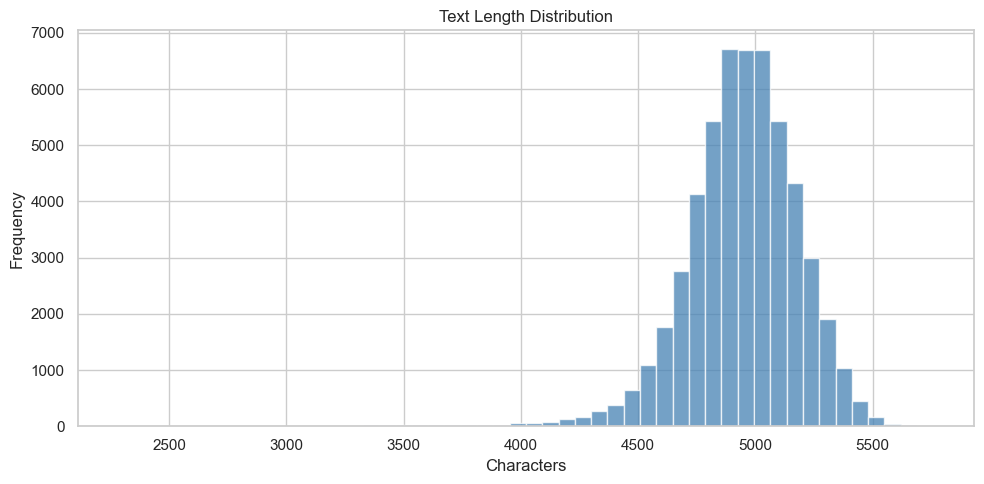

In [15]:
# Plot and save histogram of text lengths if EDA is enabled
hist_path = EDA_PLOTS_DIR / 'text_length_hist.png'
if RUN_STAGES['RUN_EDA']:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(pdf_full['text_length'], bins=50, color='steelblue', alpha=0.75)
    ax.set_title('Text Length Distribution')
    ax.set_xlabel('Characters')
    ax.set_ylabel('Frequency')
    fig.tight_layout()
    fig.savefig(hist_path, dpi=150)
    plt.show()
else:
    if hist_path.exists():
        display(Image(filename=str(hist_path)))
    else:
        print('Histogram artifact missing; enable RUN_EDA to regenerate.')


Like the earlier tables showed, most authors tend to have documents around 5000 words. Median clusters between 4 900 and 5 200 with a relatively similar IQR. 

### Boxplots of Text Length by Author

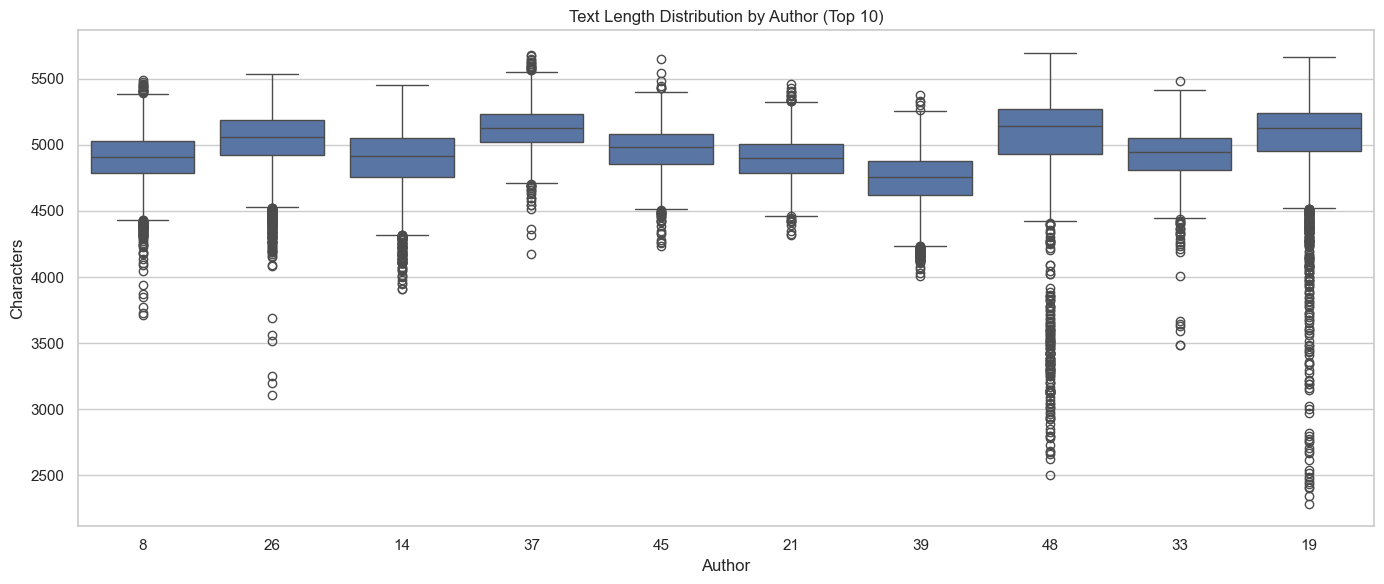

In [16]:
# Plot and save boxplot of text lengths by top authors if EDA is enabled
boxplot_path = EDA_PLOTS_DIR / 'text_length_boxplot.png'
if RUN_STAGES['RUN_EDA']:
    top_authors = pdf_full[AUTHOR_COL].value_counts().head(10).index.tolist()
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(data=pdf_full[pdf_full[AUTHOR_COL].isin(top_authors)], x=AUTHOR_COL, y='text_length', order=top_authors, ax=ax)
    ax.set_title('Text Length Distribution by Author (Top 10)')
    ax.set_xlabel('Author')
    ax.set_ylabel('Characters')
    fig.tight_layout()
    fig.savefig(boxplot_path, dpi=150)
    plt.show()
else:
    if boxplot_path.exists():
        display(Image(filename=str(boxplot_path)))
    else:
        print('Boxplot artifact missing; enable RUN_EDA to regenerate.')


Definitely some outliers present here but shorter character count may just indicate different stylometry of the author. If anything, the fact that each author is relatively varied in character count may be a useful signal in classification. Length alone may be unlikely to separate authors because central tendencies are quite similar. 

### Violin and Swarm Plots

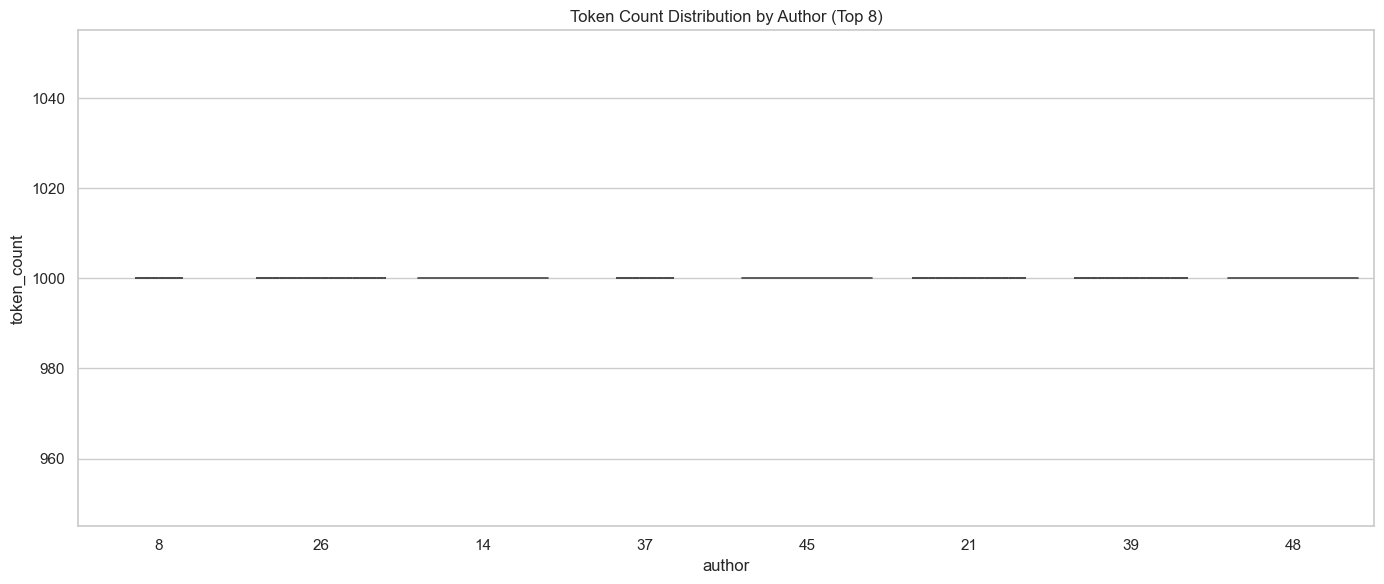

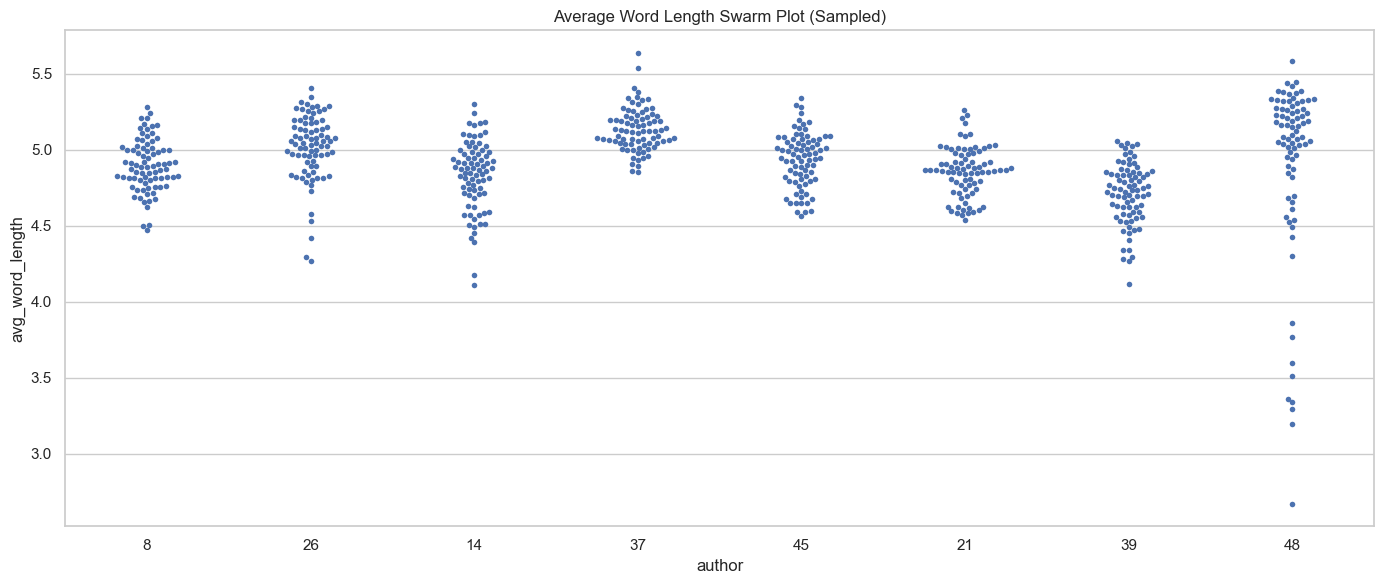

In [17]:
# Plot and save violin and swarm plots for token counts and average word lengths by top authors if EDA is enabled
violin_path = EDA_PLOTS_DIR / 'token_count_violin.png'
swarm_path = EDA_PLOTS_DIR / 'avg_word_length_swarm.png'
if RUN_STAGES['RUN_EDA']:
    top_authors_violin = pdf_full[AUTHOR_COL].value_counts().head(8).index.tolist()
    subset_violin = pdf_full[pdf_full[AUTHOR_COL].isin(top_authors_violin)].copy()

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.violinplot(data=subset_violin, x=AUTHOR_COL, y='token_count', order=top_authors_violin, inner='quartile', cut=0, ax=ax)
    ax.set_title('Token Count Distribution by Author (Top 8)')
    fig.tight_layout()
    fig.savefig(violin_path, dpi=150)
    plt.show()

    swarm_sample = subset_violin.groupby(AUTHOR_COL).apply(lambda df: df.sample(min(len(df), 80), random_state=RUN_CONFIG['seed'])).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.swarmplot(data=swarm_sample, x=AUTHOR_COL, y='avg_word_length', order=top_authors_violin, size=4, ax=ax)
    ax.set_title('Average Word Length Swarm Plot (Sampled)')
    fig.tight_layout()
    fig.savefig(swarm_path, dpi=150)
    plt.show()
else:
    if violin_path.exists():
        display(Image(filename=str(violin_path)))
    else:
        print('Violin plot artifact missing; enable RUN_EDA to regenerate.')
    if swarm_path.exists():
        display(Image(filename=str(swarm_path)))
    else:
        print('Swarm plot artifact missing; enable RUN_EDA to regenerate.')

Well token count shows absolutely nothing. The dataset clearly states that each document is 1000 tokens. Swarm plot is more interesting. Avereage word length per doc is around 4.5 and 5.3 characters. Some authors have heavier tails or outliers. May indicate usage of acronyms or other stylometric cues. Text segments according to the author's data description said if a document didn't reach 1000 tokens, each value was replaced by 1s. Author 48 may write poetry or shorter texts that don't reach the minimum token count, dragging their tail.

### Data Quality Assurance

In [ ]:
# Sanity check cleaned dataset
print(f"Cleaned dataframe rows: {len(df_clean):,}")
display(df_clean[[TEXT_COL, 'text_clean', AUTHOR_COL]].head(3))

### Normalise Text & Deduplicate

In [19]:
# Display author to index mapping
print('Author to index mapping (sample):')
display(pd.DataFrame(list(author_to_index.items()), columns=['author', 'index']).head(10))

Author to index mapping (sample):


,author,index
0,1,0
1,2,1
2,3,2
3,4,3
4,6,4
5,8,5
6,9,6
7,10,7
8,11,8
9,12,9


### Stratified Train/Validation/Test Splits

In [43]:
# Display class distribution across splits
counts_df = pd.read_csv(CLASS_COUNTS_PATH)
print('Class distribution across splits:')
display(counts_df.head(45))

Class distribution across splits:


,author_index,author,train_count,val_count,test_count,total_count
0,0,1,730,91,91,912
1,1,2,306,38,38,382
2,2,3,170,21,22,213
3,3,4,1186,149,148,1483
4,4,6,326,41,40,407
5,5,8,5531,691,692,6914
6,6,9,886,111,111,1108
7,7,10,604,76,75,755
8,8,11,306,39,38,383
9,9,12,502,63,62,627


When ordered by total count author with least documents listed at 183. Indicating ~183 000 words to train on. Author with most writing has 6 914 documents indicating ~ 6 914 000 words to train on, roughly 38 times more writing.

### Per Author Document Counts in Training Set

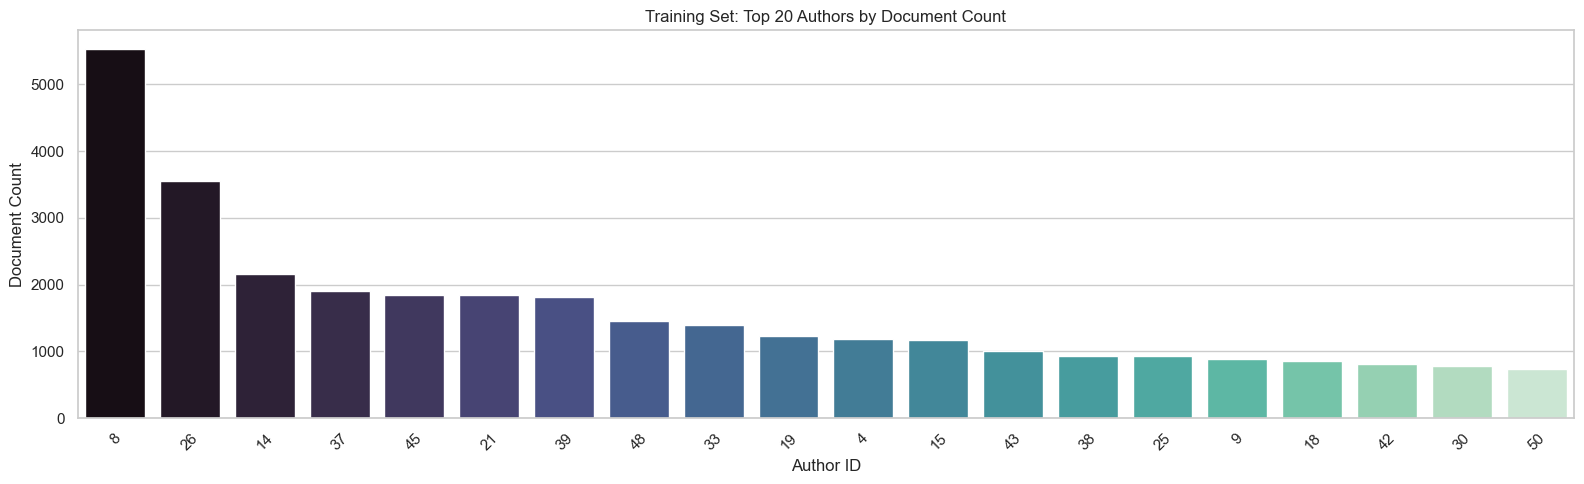

In [21]:
# Plot and save bar plot of document counts for top authors if EDA is enabled
train_author_plot_path = EDA_PLOTS_DIR / 'train_author_counts.png'
if RUN_STAGES['RUN_EDA']:
    train_author_counts = train_df[AUTHOR_COL].value_counts().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(16, 5))
    sns.barplot(x=train_author_counts.index[:20], y=train_author_counts.values[:20], palette='mako', ax=ax)
    ax.set_title('Training Set: Top 20 Authors by Document Count')
    ax.set_xlabel('Author ID')
    ax.set_ylabel('Document Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()
    fig.savefig(train_author_plot_path, dpi=150)
    plt.show()
else:
    if train_author_plot_path.exists():
        display(Image(filename=str(train_author_plot_path)))
    else:
        print('Training author distribution plot missing; enable RUN_EDA to regenerate.')


Bar chart with top 20 authors by document count. Range in counts from 700 to ~5 600. Class distribution is heavily skewed towards the authors: 8, 26, 14, 37, 45, 21 and 39. Some kind of mitigation strategy like class weighting probably makes sense here.

### Sequence Length Diagnostics

Token length percentiles:
  p50 : 994.0
  p75 : 997.0
  p90 : 999.0
  p95 : 1000.0
  p99 : 1000.0
recommended_seq_length: 1000


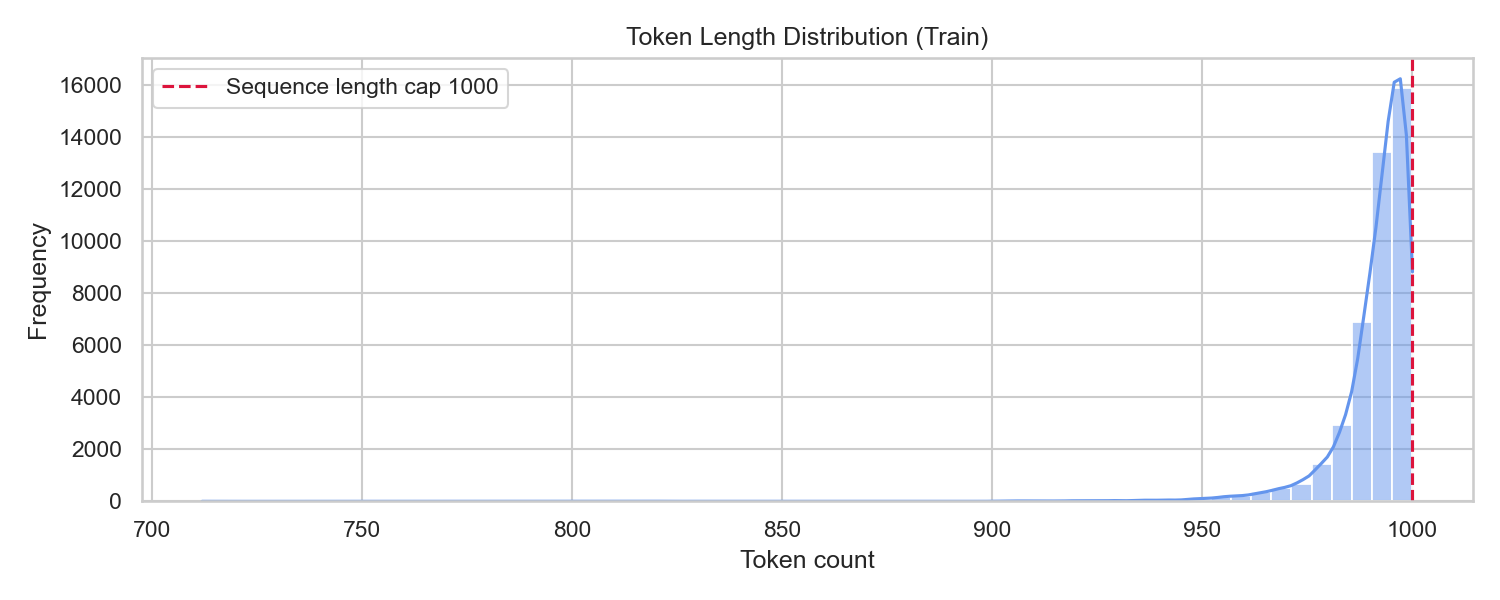

In [44]:
# Analyze token length distribution and recommend sequence length if data preprocessing is enabled
sequence_stats_path = ARTIFACTS_DIR / 'sequence_length_stats.json'
token_hist_path = EDA_PLOTS_DIR / 'token_length_hist.png'

if RUN_STAGES['RUN_DATA_PREPROCESSING']:
    train_token_lengths = train_df['text_clean'].str.split().str.len()
    percentiles = {p: float(np.percentile(train_token_lengths, p)) for p in (50, 75, 90, 95, 99)}
    print('Token length percentiles:')
    for p, value in percentiles.items():
        print(f"  p{p:<3}: {value:.1f}")

    recommended_seq_len = int(min(1200, max(400, percentiles[95])))
    RUN_CONFIG['sequence_length'] = recommended_seq_len
    RUN_CONFIG['sequence_length_stats'] = percentiles
    RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

    payload = {
        'percentiles': percentiles,
        'recommended_sequence_length': recommended_seq_len,
    }
    sequence_stats_path.write_text(json.dumps(payload, indent=2))

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.histplot(train_token_lengths, bins=60, kde=True, color='cornflowerblue', ax=ax)
    ax.axvline(recommended_seq_len, color='crimson', linestyle='--', label=f'Sequence length cap {recommended_seq_len}')
    ax.set_title('Token Length Distribution (Train)')
    ax.set_xlabel('Token count')
    ax.set_ylabel('Frequency')
    ax.legend()
    fig.tight_layout()
    fig.savefig(token_hist_path, dpi=150)
    plt.show()
else:
    if sequence_stats_path.exists():
        payload = json.loads(sequence_stats_path.read_text())
        percentiles = payload.get('percentiles', {})
        recommended_seq_len = int(payload.get('recommended_sequence_length', RUN_CONFIG['sequence_length']))
        RUN_CONFIG['sequence_length'] = recommended_seq_len
        RUN_CONFIG['sequence_length_stats'] = percentiles
        print('Token length percentiles:')
        for p, value in percentiles.items():
            print(f"  p{p:<3}: {value:.1f}")
        print("recommended_seq_length:", recommended_seq_len)
    else:
        print('Sequence length stats missing; enable RUN_DATA_PREPROCESSING to regenerate.')

    if token_hist_path.exists():
        display(Image(filename=str(token_hist_path)))
    else:
        print('Token length histogram missing; enable RUN_DATA_PREPROCESSING to regenerate.')


Whoa, who could have guessed that the recommended sequence length would be the value that the authors forced the original data into. Should keep training time relatively low and allow for decent batching.

## Data Preprocessing

### Text Vectorization Setup

In [23]:
# Initialize and fit or load the TextVectorization layer based on run stages
set_random_seeds(RUN_CONFIG['seed'])

vectorizer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=RUN_CONFIG['max_tokens'],
    output_mode='int',
    output_sequence_length=RUN_CONFIG['sequence_length'],
)

fit_vectorizer = RUN_STAGES['RUN_FEATURE_ENGINEERING'] and RUN_STAGES['RUN_MODEL_TRAINING']
if fit_vectorizer:
    text_ds = tf.data.Dataset.from_tensor_slices(train_df['text_clean'].values).batch(1024)
    vectorizer.adapt(text_ds)
    vocab = vectorizer.get_vocabulary()
    VOCAB_PATH.write_text(' '.join(vocab), encoding='utf-8')
    print(f"Vectorizer fitted -> vocabulary size {len(vocab):,}")
    RUN_CONFIG['vocab_size'] = int(len(vocab))
    RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))
else:
    if not VOCAB_PATH.exists():
        raise FileNotFoundError('Vocabulary file missing; enable RUN_FEATURE_ENGINEERING and RUN_MODEL_TRAINING to regenerate.')
    content = VOCAB_PATH.read_text(encoding='utf-8')
    if ' ' in content:
        vocab = [token for token in content.splitlines() if token]
    else:
        vocab = [token for token in content.split(' ') if token]
    vectorizer.set_vocabulary(vocab)
    RUN_CONFIG['vocab_size'] = int(len(vocab))
    print(f"Loaded vocabulary size {len(vocab):,} -> {VOCAB_PATH}")


Loaded vocabulary size 1 -> artifacts\vocabulary.txt


Tried to optimise this process by pushing vectorisation to tensorflow tensors. Converts all text to lowercase and replaces all non-alphanumeric characters with spaces. Then collapses multiple spaces into singular spaces and finall strips leading or trailing white space. Saved in artifacts\vocabulary.txt for faster reads than json as it is completely unstructured data.

### Neural Network Utilities

In [24]:
# Functions to help create datasets and track metrics during model training

def make_dataset(texts: np.ndarray, labels: np.ndarray, batch_size: int, shuffle: bool = False):
    """Create a prefetching ``tf.data.Dataset`` that vectorises ``texts`` on the fly."""

    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(texts), seed=RUN_CONFIG['seed'])
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)


class MetricsCallback(callbacks.Callback):
    """Track macro-F1/recall during training using held-out samples for early stopping."""

    def __init__(self, train_texts, train_labels, val_texts, val_labels, batch_size):
        """Initialise callback with cached sample batches for metric computation."""

        super().__init__()
        rng = np.random.default_rng(RUN_CONFIG['seed'])
        sample_size = min(RUN_CONFIG['callback_sample_size'], len(train_texts))
        self.train_indices = rng.choice(len(train_texts), size=sample_size, replace=False)
        self.train_texts = tf.constant(train_texts[self.train_indices])
        self.train_labels = np.array(train_labels[self.train_indices])
        self.val_texts = tf.constant(val_texts)
        self.val_labels = np.array(val_labels)
        self.batch_size = batch_size
        self.history = {
            'train_macro_f1': [],
            'val_macro_f1': [],
            'train_macro_recall': [],
            'val_macro_recall': [],
        }
        self.best_macro_f1 = 0.0

    def on_epoch_end(self, epoch, logs=None):
        """Compute macro metrics at epoch end and populate callback history."""

        logs = logs or {}
        train_vectors = vectorizer(self.train_texts)
        val_vectors = vectorizer(self.val_texts)

        train_probs = self.model.predict(train_vectors, verbose=0, batch_size=self.batch_size)
        val_probs = self.model.predict(val_vectors, verbose=0, batch_size=self.batch_size)

        train_preds = train_probs.argmax(axis=1)
        val_preds = val_probs.argmax(axis=1)

        train_macro_f1 = f1_score(self.train_labels, train_preds, average='macro')
        val_macro_f1 = f1_score(self.val_labels, val_preds, average='macro')
        train_macro_recall = recall_score(self.train_labels, train_preds, average='macro')
        val_macro_recall = recall_score(self.val_labels, val_preds, average='macro')

        self.history['train_macro_f1'].append(float(train_macro_f1))
        self.history['val_macro_f1'].append(float(val_macro_f1))
        self.history['train_macro_recall'].append(float(train_macro_recall))
        self.history['val_macro_recall'].append(float(val_macro_recall))

        logs['val_macro_f1'] = val_macro_f1
        logs['val_macro_recall'] = val_macro_recall

        if val_macro_f1 > self.best_macro_f1:
            self.best_macro_f1 = float(val_macro_f1)
        print(f"Epoch {epoch + 1}: val_macro_f1={val_macro_f1:.4f}, val_macro_recall={val_macro_recall:.4f}")


def build_bilstm_model(vocab_size: int, sequence_length: int, num_classes: int) -> tf.keras.Model:
    """Create the baseline BiLSTM classifier used for the closed-set author task."""

    inputs = layers.Input(shape=(sequence_length,), dtype='int32', name='token_ids')
    x = layers.Embedding(vocab_size, RUN_CONFIG['embedding_dim'], mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(RUN_CONFIG['lstm_units'], return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(RUN_CONFIG['lstm_units'] // 2, return_sequences=True))(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='closed_set_bilstm')
    optimizer = optimizers.Adam(learning_rate=RUN_CONFIG['learning_rate'], clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    return model


def build_attention_bilstm_model(vocab_size: int, sequence_length: int, num_classes: int) -> tf.keras.Model:
    """Construct a BiLSTM with additive attention pooling for richer sequence summaries."""

    inputs = layers.Input(shape=(sequence_length,), dtype='int32', name='token_ids')
    x = layers.Embedding(vocab_size, RUN_CONFIG['embedding_dim'], mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(RUN_CONFIG['lstm_units'], return_sequences=True))(x)
    attention_scores = layers.Dense(1, activation='tanh')(x)
    attention_scores = layers.Flatten()(attention_scores)
    attention_weights = layers.Activation('softmax', name='attention_weights')(attention_scores)
    context_vector = layers.Dot(axes=1)([attention_weights, x])
    x = layers.LayerNormalization()(context_vector)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='attention_bilstm')
    optimizer = optimizers.Adam(learning_rate=RUN_CONFIG['learning_rate'], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model


def build_bigru_conv_model(vocab_size: int, sequence_length: int, num_classes: int) -> tf.keras.Model:
    """Create a Conv1D front-end followed by stacked BiGRU layers for sequence modelling."""

    inputs = layers.Input(shape=(sequence_length,), dtype='int32', name='token_ids')
    x = layers.Embedding(vocab_size, RUN_CONFIG['embedding_dim'], mask_zero=True)(inputs)
    x = layers.Conv1D(filters=RUN_CONFIG['embedding_dim'], kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Bidirectional(layers.GRU(RUN_CONFIG['lstm_units'], return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(RUN_CONFIG['lstm_units'] // 2))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='bigru_conv')
    optimizer = optimizers.Adam(learning_rate=RUN_CONFIG['learning_rate'], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model


Wanted to try a few models here and creating a custom callback. 

First model to try was a bidirectional LSTM. This allows for the model to look at both past and future tokens for learning rather than only past from traditional LSTM. Embeds tokens to dense vectors -> applies dropout to embeddings to reduce overfitting -> two stacked bidirectional layers with 192 units and 96 units respectively (played with these numbers for a while to get something that had high macro-f1) -> use pooling layers to create fixed size vectors then concatenate them -> normalise activations -> apply dropout rate -> one dense layer with ReLU -> final output layer.

Second model is an attention based BiLSTM. Improves on baseline model to allow weighting of sequence elements during training by looking at more relevant parts like key phrases. Captures author style better. Similar architecture to BiLSTM base model but after first bidirectional layer it adds an attention mechanism. Dense (tanh) -> Flatten -> softmax activation -> compute context vector by weighing BiLSTM outputs -> then proceeds from normalisation onwards the same.

Last model tried is a bit weirder, a bidirectional convolutional recurrent unit model (BiGRU). Uses convolutional layers with bidirectional gated recurrent units for sequence context. Tries find n-gram features and model dependencies for the class. After embedding layer, creates a 1D convolutional section that gets local features using 3-token windows, normalises them, then downsamples to reduce sequence length. Then stacks two BiGRU layers, first one returns entire sequences, second one returns half units. Then same as before into normalisation.

Custom callback tracks macro f1 and recall during training to allow early stopping and continuous monitoring during training without TensorBoard setup. Also allows for computing metrics at end of each epoch, logs to a history file and tracks the best f1. 

`make_dataset` creates optimised tensorflow datasets that when setup correctly automatically move to GPU. 



### Prepare Datasets & Class Weights

In [45]:
# Prepare datasets and compute class weights for model training
train_texts = train_df['text_clean'].to_numpy()
val_texts = val_df['text_clean'].to_numpy()
test_texts = test_df['text_clean'].to_numpy()

train_labels = train_df['author_index'].to_numpy()
val_labels = val_df['author_index'].to_numpy()
test_labels = test_df['author_index'].to_numpy()

train_ds = make_dataset(train_texts, train_labels, RUN_CONFIG['batch_size'], shuffle=True)
val_ds = make_dataset(val_texts, val_labels, RUN_CONFIG['batch_size'], shuffle=False)
test_ds = make_dataset(test_texts, test_labels, RUN_CONFIG['batch_size'], shuffle=False)

class_weight_series = train_df['author_index'].value_counts().reindex(all_indices, fill_value=0).sort_index()
class_weights_dict = compute_inverse_sqrt_class_weights(class_weight_series)

class_weights_df = pd.DataFrame({
    'author_index': class_weight_series.index.astype(int),
    'author': [index_to_author[idx] for idx in class_weight_series.index.astype(int)],
    'document_count': class_weight_series.values.astype(int),
    'class_weight': [class_weights_dict[int(idx)] for idx in class_weight_series.index.astype(int)],
})
class_weights_path = METRICS_DIR / 'class_weights.csv'
class_weights_df.to_csv(class_weights_path, index=False)
print('Class weight table:')
display(class_weights_df.head(45))
print(f"Class weight range: {min(class_weights_dict.values()):.3f} -> {max(class_weights_dict.values()):.3f}")

NUM_CLASSES = len(author_to_index)
LABELS_ORDERED = [index_to_author[idx] for idx in range(NUM_CLASSES)]


Class weight table:


,author_index,author,document_count,class_weight
0,0,1,730,0.912808
1,1,2,306,1.409873
2,2,3,170,1.891543
3,3,4,1186,0.716141
4,4,6,326,1.365941
5,5,8,5531,0.331619
6,6,9,886,0.828560
7,7,10,604,1.003511
8,8,11,306,1.409873
9,9,12,502,1.100750


Class weight range: 0.332 -> 2.041


Class weight range from 0.332 to 2.041. Not quite the same weighting between author document counts but inverse square roots are normalised to be around 1. 

## Feature Engineering

### Feature Selection with TF-IDF Chi-Square

In [26]:
# Perform feature engineering using chi-square feature selection if enabled
if RUN_STAGES['RUN_FEATURE_ENGINEERING']:
    text_vectorizer_full = TfidfVectorizer(max_features=60000, ngram_range=(1, 2), sublinear_tf=True)
    X_train_tfidf = text_vectorizer_full.fit_transform(train_df['text_clean'])
    selector_k = min(30000, X_train_tfidf.shape[1])
    chi2_selector = SelectKBest(chi2, k=selector_k)
    chi2_selector.fit(X_train_tfidf, train_df['author_index'])

    feature_scores = pd.DataFrame({
        'feature': text_vectorizer_full.get_feature_names_out(),
        'chi2': chi2_selector.scores_,
        'pvalue': chi2_selector.pvalues_,
    }).sort_values('chi2', ascending=False)
    feature_scores.to_csv(FEATURE_RANK_PATH, index=False)
    print(f"Chi-square feature ranking saved -> {FEATURE_RANK_PATH}")
    print('Top 15 features by chi-square score:')
    display(feature_scores.head(15))

    RUN_CONFIG['chi2_k'] = int(selector_k)
    RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

    sgd_probe = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-5, max_iter=1000, tol=1e-3, class_weight='balanced', random_state=RUN_CONFIG['seed'])
    sgd_probe.fit(X_train_tfidf, train_df['author_index'])
    top_terms = {}
    coef_matrix = sgd_probe.coef_
    feature_names = text_vectorizer_full.get_feature_names_out()
    for class_idx in range(NUM_CLASSES):
        indices = np.argsort(coef_matrix[class_idx])[-15:][::-1]
        top_terms[index_to_author[class_idx]] = [feature_names[i] for i in indices]
    TOP_TERMS_PATH.write_text(json.dumps(top_terms, indent=2))
    print(f"Top terms per class saved -> {TOP_TERMS_PATH}")
else:
    if not FEATURE_RANK_PATH.exists() or not TOP_TERMS_PATH.exists():
        raise FileNotFoundError('Feature engineering artifacts missing; enable RUN_FEATURE_ENGINEERING to regenerate.')
    feature_scores = pd.read_csv(FEATURE_RANK_PATH)
    print('Top 15 features by chi-square score (loaded):')
    display(feature_scores.head(15))

RUN_CONFIG['chi2_k'] = int(RUN_CONFIG.get('chi2_k', feature_scores.shape[0]))


Top 15 features by chi-square score (loaded):


,feature,chi2,pvalue
0,the idiot,2258.480256,0.000000e+00
1,of arc,1756.363878,0.000000e+00
2,young america,1490.868090,7.704606e-284
3,de claim,1214.632538,1.010465e-225
4,idiot,1014.502824,6.655481e-184
5,england tale,943.704974,3.454483e-169
6,lady life,941.893250,8.209315e-169
7,mark twain,881.360907,2.846557e-156
8,john marvel,879.540269,6.774108e-156
9,enchanted type,833.634798,2.048403e-146


A form of statistical feature selection by identifying most informative n-grams. Code vectorises using TF-IDF into a sparse matrix of up to 60 000 features. Best n-grams are selected using Chi-Square. p-value of zero indicates that the phrases are non-random, helping separate classes in imbalanced data. Super high chi2 values indicate author-specific phrases. the phrase mark twain was probably in a book by Mark Twain. the idiot and idiot at are likely from Dostoevsky's The Idiot. This process also gets rid of irrelevant stopwords like 'the' or 'and', especially considering their frequency from the EDA and general noise.

## Model Training

### Initialise Results Container

In [27]:
MODEL_RESULTS = []
BASELINE_ROC_DATA = None
BILSTM_ROC_DATA = None

### Baseline: TF-IDF + Stylometric SGDClassifier  
Note: CPU only with sklearn

In [28]:
# Train and evaluate the baseline TF-IDF + SGD model if enabled
baseline_pipeline_path = MODELS_DIR / 'baseline_tfidf_sgd.joblib'
baseline_metrics_path = METRICS_DIR / 'baseline_tfidf_sgd.json'
baseline_roc_path = METRICS_DIR / 'baseline_tfidf_sgd_roc.json'

text_features = 'text_clean'
style_features = ['text_length', 'token_count', 'unique_token_count', 'avg_word_length', 'digit_density', 'punctuation_density']

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=60000, ngram_range=(1, 2), sublinear_tf=True)),
    ('chi2', SelectKBest(chi2, k=RUN_CONFIG['chi2_k'])),
])
style_pipeline = Pipeline([('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
    ('text', text_pipeline, text_features),
    ('style', style_pipeline, style_features),
])

if RUN_STAGES['RUN_MODEL_TRAINING']:
    baseline_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=1e-5,
            max_iter=200,
            tol=1e-3,
            class_weight='balanced',
            random_state=RUN_CONFIG['seed'],
        )),
    ])
    print('Training baseline TF-IDF + SGD pipeline...')
    baseline_pipeline.fit(train_df[[text_features] + style_features], train_df['author_index'])

    joblib.dump(baseline_pipeline, baseline_pipeline_path)
    print(f"Baseline pipeline saved -> {baseline_pipeline_path}")

    print('Evaluating baseline model...')
    train_preds = baseline_pipeline.predict(train_df[[text_features] + style_features])
    val_preds = baseline_pipeline.predict(val_df[[text_features] + style_features])
    val_probs = baseline_pipeline.predict_proba(val_df[[text_features] + style_features])

    train_acc = accuracy_score(train_df['author_index'], train_preds)
    val_acc = accuracy_score(val_df['author_index'], val_preds)
    val_macro_f1 = f1_score(val_df['author_index'], val_preds, average='macro')
    val_macro_recall = recall_score(val_df['author_index'], val_preds, average='macro')
    val_macro_precision = precision_score(val_df['author_index'], val_preds, average='macro')
    val_top3 = top_k_accuracy_score(val_df['author_index'], val_probs, k=3)

    val_roc_auc = roc_auc_score(
        label_binarize(val_df['author_index'], classes=list(range(NUM_CLASSES))),
        val_probs,
        average='macro',
        multi_class='ovr',
    )

    print('Validation classification report:')
    print(classification_report(val_df['author_index'], val_preds))

    cm_baseline = plot_conf_matrix(val_df['author_index'], val_preds, LABELS_ORDERED, 'Baseline TF-IDF + SGD Confusion Matrix')

    baseline_metrics = {
        'model': 'tfidf_sgd',
        'val_accuracy': float(val_acc),
        'val_macro_f1': float(val_macro_f1),
        'val_macro_recall': float(val_macro_recall),
        'val_macro_precision': float(val_macro_precision),
        'val_top3_accuracy': float(val_top3),
        'val_roc_auc_macro': float(val_roc_auc),
        'train_accuracy': float(train_acc),
    }
    MODEL_RESULTS.append(baseline_metrics)

    baseline_payload = {
        **baseline_metrics,
        'classification_report': classification_report(val_df['author_index'], val_preds, output_dict=True, zero_division=0),
        'confusion_matrix': cm_baseline.tolist(),
    }
    baseline_metrics_path.write_text(json.dumps(baseline_payload, indent=2))
    print(f"Baseline metrics saved -> {baseline_metrics_path}")

    BASELINE_ROC_DATA = macro_roc_curve(val_df['author_index'], val_probs, NUM_CLASSES)
    baseline_roc_path.write_text(json.dumps({
        'fpr': BASELINE_ROC_DATA[0].tolist(),
        'tpr': BASELINE_ROC_DATA[1].tolist(),
        'auc': BASELINE_ROC_DATA[2],
    }, indent=2))
    print(f"Baseline ROC saved -> {baseline_roc_path}")
else:
    if not baseline_pipeline_path.exists() or not baseline_metrics_path.exists() or not baseline_roc_path.exists():
        raise FileNotFoundError('Baseline artifacts missing; enable RUN_MODEL_TRAINING to regenerate.')

    baseline_pipeline = joblib.load(baseline_pipeline_path)
    baseline_payload = json.loads(baseline_metrics_path.read_text())
    MODEL_RESULTS.append({key: baseline_payload[key] for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro', 'train_accuracy']})

    roc_payload = json.loads(baseline_roc_path.read_text())
    BASELINE_ROC_DATA = (
        np.array(roc_payload['fpr']),
        np.array(roc_payload['tpr']),
        float(roc_payload['auc']),
    )
    print('Loaded baseline metrics and ROC curve from disk.')

Loaded baseline metrics and ROC curve from disk.


### Train BiLSTM Model

In [29]:
# Train and evaluate the BiLSTM model if enabled
best_model_path = MODELS_DIR / 'bilstm_closed_best.keras'
last_model_path = MODELS_DIR / 'bilstm_closed_last.keras'
history_path = MODELS_DIR / 'bilstm_closed_history.json'
if RUN_STAGES['RUN_MODEL_BILSTM']:
    if RUN_STAGES['RUN_MODEL_TRAINING']:
        model = build_bilstm_model(len(vocab), RUN_CONFIG['sequence_length'], NUM_CLASSES)
        metrics_cb = MetricsCallback(train_texts, train_labels, val_texts, val_labels, RUN_CONFIG['batch_size'])

        callbacks_list = [
            metrics_cb,
            callbacks.ModelCheckpoint(filepath=str(best_model_path), monitor='val_macro_f1', mode='max', save_best_only=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_macro_f1', mode='max', factor=0.5, patience=2, verbose=1),
            callbacks.EarlyStopping(monitor='val_macro_f1', mode='max', patience=4, restore_best_weights=True, verbose=1),
        ]

        print('Training BiLSTM model...')
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=RUN_CONFIG['epochs'],
            callbacks=callbacks_list,
            class_weight=class_weights_dict,
        )

        RUN_CONFIG['trained_epochs'] = len(history.history['loss'])
        RUN_CONFIG['best_val_macro_f1'] = float(metrics_cb.best_macro_f1)
        RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

        model.save(last_model_path, include_optimizer=False)
        print(f"Saved last-epoch model -> {last_model_path}")

        history_payload = {key: [float(v) for v in values] for key, values in history.history.items()}
        history_payload['train_macro_recall'] = metrics_cb.history['train_macro_recall']
        history_payload['val_macro_recall'] = metrics_cb.history['val_macro_recall']
        history_payload['train_macro_f1'] = metrics_cb.history['train_macro_f1']
        history_payload['val_macro_f1'] = metrics_cb.history['val_macro_f1']
        history_path.write_text(json.dumps(history_payload, indent=2))
        print(f"Training history saved -> {history_path}")

        plot_learning_curves(history, metrics_cb, title_prefix='BiLSTM')
    else:
        if not best_model_path.exists() or not history_path.exists():
            raise FileNotFoundError('BiLSTM artifacts missing; enable RUN_MODEL_TRAINING to regenerate.')
        print('Skipping BiLSTM training; using persisted weights for evaluation.')
else:
    print('Skipping BiLSTM training; using persisted weights for evaluation.')

Skipping BiLSTM training; using persisted weights for evaluation.


### Train Attention BiLSTM Model

In [30]:
# Train and evaluate the Attention BiLSTM model if enabled
attention_best_path = MODELS_DIR / 'attention_bilstm_best.keras'
attention_history_path = MODELS_DIR / 'attention_bilstm_history.json'
attention_val_predictions_path = ARTIFACTS_DIR / 'attention_val_predictions.parquet'

if RUN_STAGES['RUN_MODEL_ATTENTION_LSTM']:
    if RUN_STAGES['RUN_MODEL_TRAINING']:
        attention_model = build_attention_bilstm_model(len(vocab), RUN_CONFIG['sequence_length'], NUM_CLASSES)
        attention_cb = MetricsCallback(train_texts, train_labels, val_texts, val_labels, RUN_CONFIG['batch_size'])
        attention_callbacks = [
            attention_cb,
            callbacks.ModelCheckpoint(filepath=str(attention_best_path), monitor='val_macro_f1', mode='max', save_best_only=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_macro_f1', mode='max', factor=0.5, patience=2, verbose=1),
            callbacks.EarlyStopping(monitor='val_macro_f1', mode='max', patience=4, restore_best_weights=True, verbose=1),
        ]

        attention_history = attention_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=RUN_CONFIG['epochs'],
            callbacks=attention_callbacks,
            class_weight=class_weights_dict,
        )

        attention_model.save(attention_best_path, include_optimizer=False)
        print(f"Saved best attention BiLSTM model -> {attention_best_path}")

        attention_history_payload = {key: [float(v) for v in values] for key, values in attention_history.history.items()}
        attention_history_payload['train_macro_f1'] = attention_cb.history['train_macro_f1']
        attention_history_payload['val_macro_f1'] = attention_cb.history['val_macro_f1']
        attention_history_payload['train_macro_recall'] = attention_cb.history['train_macro_recall']
        attention_history_payload['val_macro_recall'] = attention_cb.history['val_macro_recall']
        attention_history_path.write_text(json.dumps(attention_history_payload, indent=2))
        print(f"Attention BiLSTM history saved -> {attention_history_path}")

        plot_learning_curves(attention_history, attention_cb, title_prefix='Attention BiLSTM')
    else:
        if not attention_best_path.exists() or not attention_history_path.exists():
            raise FileNotFoundError('Attention BiLSTM artifacts missing; enable RUN_MODEL_TRAINING to regenerate.')
        print('Skipping Attention BiLSTM training; using persisted weights for evaluation.')
else:
    print('Skipping Attention BiLSTM training; using persisted weights for evaluation.')


Skipping Attention BiLSTM training; using persisted weights for evaluation.


### Train BiGRU Conv Model

In [ ]:
# Train and evaluate the BiGRU + Conv1D model if enabled
bigru_best_path = MODELS_DIR / 'bigru_conv_best.keras'
bigru_history_path = MODELS_DIR / 'bigru_conv_history.json'
bigru_val_predictions_path = ARTIFACTS_DIR / 'bigru_conv_val_predictions.parquet'

if RUN_STAGES['RUN_MODEL_BIGRU']:
    if RUN_STAGES['RUN_MODEL_TRAINING']:
        bigru_model = build_bigru_conv_model(len(vocab), RUN_CONFIG['sequence_length'], NUM_CLASSES)
        bigru_cb = MetricsCallback(train_texts, train_labels, val_texts, val_labels, RUN_CONFIG['batch_size'])
        bigru_callbacks = [
            bigru_cb,
            callbacks.ModelCheckpoint(filepath=str(bigru_best_path), monitor='val_macro_f1', mode='max', save_best_only=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_macro_f1', mode='max', factor=0.5, patience=2, verbose=1),
            callbacks.EarlyStopping(monitor='val_macro_f1', mode='max', patience=4, restore_best_weights=True, verbose=1),
        ]

        bigru_history = bigru_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=RUN_CONFIG['epochs'],
            callbacks=bigru_callbacks,
            class_weight=class_weights_dict,
        )

        bigru_model.save(bigru_best_path, include_optimizer=False)
        print(f"Saved best BiGRU Conv model -> {bigru_best_path}")

        bigru_history_payload = {key: [float(v) for v in values] for key, values in bigru_history.history.items()}
        bigru_history_payload['train_macro_f1'] = bigru_cb.history['train_macro_f1']
        bigru_history_payload['val_macro_f1'] = bigru_cb.history['val_macro_f1']
        bigru_history_payload['train_macro_recall'] = bigru_cb.history['train_macro_recall']
        bigru_history_payload['val_macro_recall'] = bigru_cb.history['val_macro_recall']
        bigru_history_path.write_text(json.dumps(bigru_history_payload, indent=2))
        print(f"BiGRU Conv history saved -> {bigru_history_path}")

        plot_learning_curves(bigru_history, bigru_cb, title_prefix='BiGRU Conv')
    else:
        if not bigru_best_path.exists() or not bigru_history_path.exists():
            raise FileNotFoundError('BiGRU Conv artifacts missing; enable RUN_MODEL_TRAINING to regenerate.')
        print('Skipping BiGRU Conv training; using persisted weights for evaluation.')
else:
    print('Skipping BiGRU Conv training; using persisted weights for evaluation.')


Skipping BiGRU Conv training; using persisted weights for evaluation.


## Model Evaluation

### Evaluate BiLSTM

In [32]:
# Evaluate the BiLSTM model and save metrics, ROC curve, and validation predictions if enabled
bilstm_metrics_path = METRICS_DIR / 'bilstm_closed_metrics.json'
bilstm_roc_path = METRICS_DIR / 'bilstm_closed_roc.json'

BILSTM_ROC_DATA = None
if RUN_STAGES['RUN_MODEL_BILSTM'] and RUN_STAGES['RUN_MODEL_EVALUATION']:
    best_model = tf.keras.models.load_model(best_model_path)
    val_vectors = vectorizer(tf.constant(val_texts))
    val_probabilities = best_model.predict(val_vectors, batch_size=RUN_CONFIG['batch_size'], verbose=0)
    val_predictions = val_probabilities.argmax(axis=1)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')
    val_macro_recall = recall_score(val_labels, val_predictions, average='macro')
    val_macro_precision = precision_score(val_labels, val_predictions, average='macro')
    val_top3 = top_k_accuracy_score(val_labels, val_probabilities, k=3)
    val_roc_auc = roc_auc_score(
        label_binarize(val_labels, classes=list(range(NUM_CLASSES))),
        val_probabilities,
        average='macro',
        multi_class='ovr',
    )

    print('Validation classification report (BiLSTM):')
    print(classification_report(val_labels, val_predictions))

    cm_bilstm = plot_conf_matrix(val_labels, val_predictions, LABELS_ORDERED, 'BiLSTM Confusion Matrix')

    metrics_payload = {
        'model': 'bilstm',
        'val_accuracy': float(val_accuracy),
        'val_macro_f1': float(val_macro_f1),
        'val_macro_recall': float(val_macro_recall),
        'val_macro_precision': float(val_macro_precision),
        'val_top3_accuracy': float(val_top3),
        'val_roc_auc_macro': float(val_roc_auc),
        'best_val_macro_f1': RUN_CONFIG.get('best_val_macro_f1'),
    }
    MODEL_RESULTS.append(metrics_payload)

    bilstm_metrics_path.write_text(json.dumps({
        **metrics_payload,
        'classification_report': classification_report(val_labels, val_predictions, output_dict=True, zero_division=0),
        'confusion_matrix': cm_bilstm.tolist(),
    }, indent=2))
    print(f"BiLSTM metrics saved -> {bilstm_metrics_path}")

    val_prediction_rows = pd.DataFrame({
        'text_id': val_df.index,
        'author_true': val_df[AUTHOR_COL].values,
        'author_index_true': val_labels,
        'author_index_pred': val_predictions,
        'author_pred': [index_to_author[int(idx)] for idx in val_predictions],
        'text': val_df[TEXT_COL].values,
        'text_clean': val_df['text_clean'].values,
    })
    val_prediction_rows.to_parquet(VAL_PREDICTIONS_PATH, index=False)
    print(f"Validation predictions saved -> {VAL_PREDICTIONS_PATH}")

    BILSTM_ROC_DATA = macro_roc_curve(val_labels, val_probabilities, NUM_CLASSES)
    bilstm_roc_path.write_text(json.dumps({
        'fpr': BILSTM_ROC_DATA[0].tolist(),
        'tpr': BILSTM_ROC_DATA[1].tolist(),
        'auc': BILSTM_ROC_DATA[2],
    }, indent=2))
    print(f"BiLSTM ROC saved -> {bilstm_roc_path}")
elif RUN_STAGES['RUN_MODEL_BILSTM']:
    if not bilstm_metrics_path.exists() or not bilstm_roc_path.exists() or not VAL_PREDICTIONS_PATH.exists():
        raise FileNotFoundError('BiLSTM evaluation artifacts missing; enable RUN_MODEL_EVALUATION to regenerate.')

    metrics_payload = json.loads(bilstm_metrics_path.read_text())
    MODEL_RESULTS.append({key: metrics_payload.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro', 'best_val_macro_f1']})

    roc_payload = json.loads(bilstm_roc_path.read_text())
    BILSTM_ROC_DATA = (
        np.array(roc_payload['fpr']),
        np.array(roc_payload['tpr']),
        float(roc_payload['auc']),
    )
    print('Loaded BiLSTM metrics, ROC data, and validation predictions from disk.')
else:
    if bilstm_metrics_path.exists() and bilstm_roc_path.exists():
        metrics_payload = json.loads(bilstm_metrics_path.read_text())
        MODEL_RESULTS.append({key: metrics_payload.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro', 'best_val_macro_f1']})

        roc_payload = json.loads(bilstm_roc_path.read_text())
        BILSTM_ROC_DATA = (
            np.array(roc_payload['fpr']),
            np.array(roc_payload['tpr']),
            float(roc_payload['auc']),
        )
        print('BiLSTM disabled; reused cached metrics and ROC curve from disk.')
    else:
        print('BiLSTM artifacts unavailable; enable RUN_MODEL_BILSTM to generate fresh metrics.')

BiLSTM disabled; reused cached metrics and ROC curve from disk.


### Evaluate Attention BiLSTM

In [33]:
# Evaluate the Attention BiLSTM model and save metrics, ROC curve, and validation predictions if enabled
attention_metrics_path = METRICS_DIR / 'attention_bilstm_metrics.json'
attention_roc_path = METRICS_DIR / 'attention_bilstm_roc.json'
attention_best_path = MODELS_DIR / 'attention_bilstm_best.keras'
attention_val_predictions_path = ARTIFACTS_DIR / 'attention_val_predictions.parquet'

ATTENTION_ROC_DATA = None
if RUN_STAGES['RUN_MODEL_ATTENTION_LSTM'] and RUN_STAGES['RUN_MODEL_EVALUATION']:
    attention_model = tf.keras.models.load_model(attention_best_path)
    val_vectors = vectorizer(tf.constant(val_texts))
    val_probabilities = attention_model.predict(val_vectors, batch_size=RUN_CONFIG['batch_size'], verbose=0)
    val_predictions = val_probabilities.argmax(axis=1)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')
    val_macro_recall = recall_score(val_labels, val_predictions, average='macro')
    val_macro_precision = precision_score(val_labels, val_predictions, average='macro')
    val_top3 = top_k_accuracy_score(val_labels, val_probabilities, k=3)
    val_roc_auc = roc_auc_score(
        label_binarize(val_labels, classes=list(range(NUM_CLASSES))),
        val_probabilities,
        average='macro',
        multi_class='ovr',
    )

    print('Validation classification report (Attention BiLSTM):')
    print(classification_report(val_labels, val_predictions))

    cm_attention = plot_conf_matrix(val_labels, val_predictions, LABELS_ORDERED, 'Attention BiLSTM Confusion Matrix')

    attention_metrics = {
        'model': 'attention_bilstm',
        'val_accuracy': float(val_accuracy),
        'val_macro_f1': float(val_macro_f1),
        'val_macro_recall': float(val_macro_recall),
        'val_macro_precision': float(val_macro_precision),
        'val_top3_accuracy': float(val_top3),
        'val_roc_auc_macro': float(val_roc_auc),
    }
    MODEL_RESULTS.append(attention_metrics)

    attention_metrics_path.write_text(json.dumps({
        **attention_metrics,
        'classification_report': classification_report(val_labels, val_predictions, output_dict=True, zero_division=0),
        'confusion_matrix': cm_attention.tolist(),
    }, indent=2))
    print(f"Attention BiLSTM metrics saved -> {attention_metrics_path}")

    val_prediction_rows = pd.DataFrame({
        'text_id': val_df.index,
        'author_true': val_df[AUTHOR_COL].values,
        'author_index_true': val_labels,
        'author_index_pred': val_predictions,
        'author_pred': [index_to_author[int(idx)] for idx in val_predictions],
        'text': val_df[TEXT_COL].values,
        'text_clean': val_df['text_clean'].values,
    })
    val_prediction_rows.to_parquet(attention_val_predictions_path, index=False)
    print(f"Attention BiLSTM validation predictions saved -> {attention_val_predictions_path}")

    ATTENTION_ROC_DATA = macro_roc_curve(val_labels, val_probabilities, NUM_CLASSES)
    attention_roc_path.write_text(json.dumps({
        'fpr': ATTENTION_ROC_DATA[0].tolist(),
        'tpr': ATTENTION_ROC_DATA[1].tolist(),
        'auc': ATTENTION_ROC_DATA[2],
    }, indent=2))
    print(f"Attention BiLSTM ROC saved -> {attention_roc_path}")
elif RUN_STAGES['RUN_MODEL_ATTENTION_LSTM']:
    if not attention_metrics_path.exists() or not attention_roc_path.exists() or not attention_val_predictions_path.exists():
        raise FileNotFoundError('Attention BiLSTM evaluation artifacts missing; enable RUN_MODEL_EVALUATION to regenerate.')

    attention_metrics = json.loads(attention_metrics_path.read_text())
    MODEL_RESULTS.append({key: attention_metrics.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro']})

    roc_payload = json.loads(attention_roc_path.read_text())
    ATTENTION_ROC_DATA = (
        np.array(roc_payload['fpr']),
        np.array(roc_payload['tpr']),
        float(roc_payload['auc']),
    )
    print('Loaded Attention BiLSTM metrics and ROC data from disk.')
else:
    if attention_metrics_path.exists() and attention_roc_path.exists():
        attention_metrics = json.loads(attention_metrics_path.read_text())
        MODEL_RESULTS.append({key: attention_metrics.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro']})

        roc_payload = json.loads(attention_roc_path.read_text())
        ATTENTION_ROC_DATA = (
            np.array(roc_payload['fpr']),
            np.array(roc_payload['tpr']),
            float(roc_payload['auc']),
        )
        print('Attention BiLSTM disabled; reused cached metrics and ROC curve from disk.')
    else:
        print('Attention BiLSTM artifacts unavailable; enable RUN_MODEL_ATTENTION_LSTM to generate fresh metrics.')

Attention BiLSTM disabled; reused cached metrics and ROC curve from disk.


### Evaluate BiGRU Conv Model

In [ ]:
# Evaluate the BiGRU + Conv1D model and save metrics, ROC curve, and validation predictions if enabled
bigru_metrics_path = METRICS_DIR / 'bigru_conv_metrics.json'
bigru_roc_path = METRICS_DIR / 'bigru_conv_roc.json'
bigru_best_path = MODELS_DIR / 'bigru_conv_best.keras'
bigru_val_predictions_path = ARTIFACTS_DIR / 'bigru_conv_val_predictions.parquet'

BIGRU_ROC_DATA = None
if RUN_STAGES['RUN_MODEL_BIGRU'] and RUN_STAGES['RUN_MODEL_EVALUATION']:
    bigru_model = tf.keras.models.load_model(bigru_best_path)
    val_vectors = vectorizer(tf.constant(val_texts))
    val_probabilities = bigru_model.predict(val_vectors, batch_size=RUN_CONFIG['batch_size'], verbose=0)
    val_predictions = val_probabilities.argmax(axis=1)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')
    val_macro_recall = recall_score(val_labels, val_predictions, average='macro')
    val_macro_precision = precision_score(val_labels, val_predictions, average='macro')
    val_top3 = top_k_accuracy_score(val_labels, val_probabilities, k=3)
    val_roc_auc = roc_auc_score(
        label_binarize(val_labels, classes=list(range(NUM_CLASSES))),
        val_probabilities,
        average='macro',
        multi_class='ovr',
    )

    print('Validation classification report (BiGRU Conv):')
    print(classification_report(val_labels, val_predictions))

    cm_bigru = plot_conf_matrix(val_labels, val_predictions, LABELS_ORDERED, 'BiGRU Conv Confusion Matrix')

    bigru_metrics = {
        'model': 'bigru_conv',
        'val_accuracy': float(val_accuracy),
        'val_macro_f1': float(val_macro_f1),
        'val_macro_recall': float(val_macro_recall),
        'val_macro_precision': float(val_macro_precision),
        'val_top3_accuracy': float(val_top3),
        'val_roc_auc_macro': float(val_roc_auc),
    }
    MODEL_RESULTS.append(bigru_metrics)

    bigru_metrics_path.write_text(json.dumps({
        **bigru_metrics,
        'classification_report': classification_report(val_labels, val_predictions, output_dict=True, zero_division=0),
        'confusion_matrix': cm_bigru.tolist(),
    }, indent=2))
    print(f"BiGRU Conv metrics saved -> {bigru_metrics_path}")

    val_prediction_rows = pd.DataFrame({
        'text_id': val_df.index,
        'author_true': val_df[AUTHOR_COL].values,
        'author_index_true': val_labels,
        'author_index_pred': val_predictions,
        'author_pred': [index_to_author[int(idx)] for idx in val_predictions],
        'text': val_df[TEXT_COL].values,
        'text_clean': val_df['text_clean'].values,
    })
    val_prediction_rows.to_parquet(bigru_val_predictions_path, index=False)
    print(f"BiGRU Conv validation predictions saved -> {bigru_val_predictions_path}")

    BIGRU_ROC_DATA = macro_roc_curve(val_labels, val_probabilities, NUM_CLASSES)
    bigru_roc_path.write_text(json.dumps({
        'fpr': BIGRU_ROC_DATA[0].tolist(),
        'tpr': BIGRU_ROC_DATA[1].tolist(),
        'auc': BIGRU_ROC_DATA[2],
    }, indent=2))
    print(f"BiGRU Conv ROC saved -> {bigru_roc_path}")
elif RUN_STAGES['RUN_MODEL_BIGRU']:
    if not bigru_metrics_path.exists() or not bigru_roc_path.exists() or not bigru_val_predictions_path.exists():
        raise FileNotFoundError('BiGRU Conv evaluation artifacts missing; enable RUN_MODEL_EVALUATION to regenerate.')

    bigru_metrics = json.loads(bigru_metrics_path.read_text())
    MODEL_RESULTS.append({key: bigru_metrics.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro']})

    roc_payload = json.loads(bigru_roc_path.read_text())
    BIGRU_ROC_DATA = (
        np.array(roc_payload['fpr']),
        np.array(roc_payload['tpr']),
        float(roc_payload['auc']),
    )
    print('Loaded BiGRU Conv metrics and ROC data from disk.')
else:
    if bigru_metrics_path.exists() and bigru_roc_path.exists():
        bigru_metrics = json.loads(bigru_metrics_path.read_text())
        MODEL_RESULTS.append({key: bigru_metrics.get(key) for key in ['model', 'val_accuracy', 'val_macro_f1', 'val_macro_recall', 'val_macro_precision', 'val_top3_accuracy', 'val_roc_auc_macro']})

        roc_payload = json.loads(bigru_roc_path.read_text())
        BIGRU_ROC_DATA = (
            np.array(roc_payload['fpr']),
            np.array(roc_payload['tpr']),
            float(roc_payload['auc']),
        )
        print('BiGRU Conv disabled; reused cached metrics and ROC curve from disk.')
    else:
        print('BiGRU Conv artifacts unavailable; enable RUN_MODEL_BIGRU_CAPSULE to generate fresh metrics.')

BiGRU Conv disabled; reused cached metrics and ROC curve from disk.


**Well, that took forever**
All models completed training after several iterations and some very low scoring models made. Interested in seeing if my prediction of BiLSTM outperforming SGDClassifier and attention BiLSTM outperforming them all is correct.

### ROC Curves (Macro-Average)

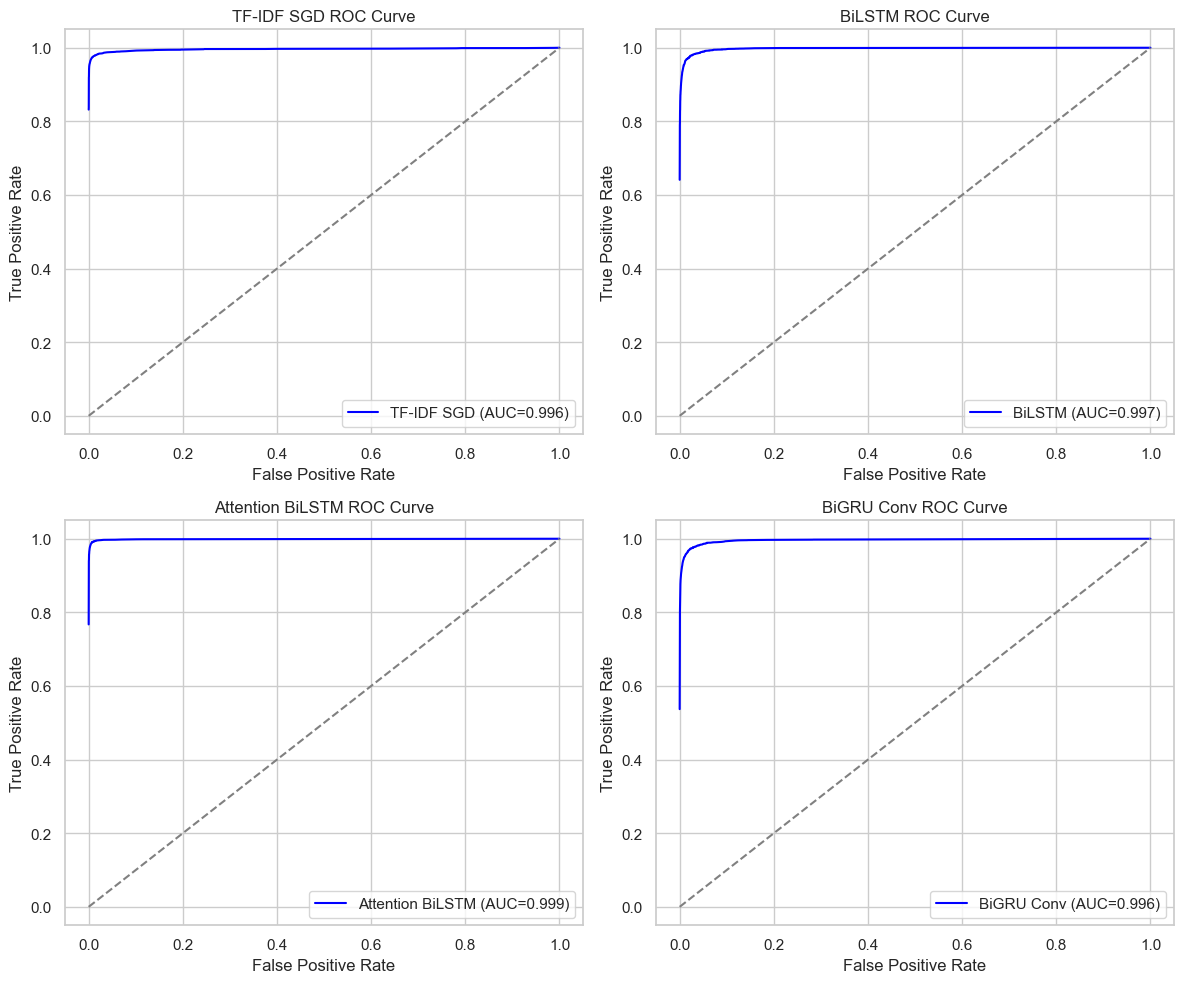

In [ ]:
# Summarize and display all model results in a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily index

MODEL_COMPARISON_PLOT_PATH = REPORTS_DIR / 'model_comparison_roc.png'

# List of models and their data for iteration
models_data = [
    ('TF-IDF SGD', BASELINE_ROC_DATA),
    ('BiLSTM', BILSTM_ROC_DATA),
    ('Attention BiLSTM', ATTENTION_ROC_DATA if 'ATTENTION_ROC_DATA' in globals() else None),
    ('BiGRU Conv', BIGRU_ROC_DATA if 'BIGRU_ROC_DATA' in globals() else None),
]

for idx, (model_name, roc_data) in enumerate(models_data):
    ax = axes[idx]
    if roc_data is not None:
        fpr, tpr, auc_val = roc_data
        ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc_val:.3f})', color='blue')
    else:
        ax.text(0.5, 0.5, f'{model_name}\n(No data)', ha='center', va='center', transform=ax.transAxes)
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_title(f'{model_name} ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.grid(True)
plt.savefig(MODEL_COMPARISON_PLOT_PATH)
plt.tight_layout()
plt.show()

All models performed really well. This is most likely due to the variety in stylistic differences from Victorian Era authors. Based on EDA there were some terms that separated out authors extremely easily like 'mark twain' for documents by Mark Twain. Think this may also be because feature engineering was quite robust. TF-IDF is a really good way to identify stylometric signals. Class weighting also helped.

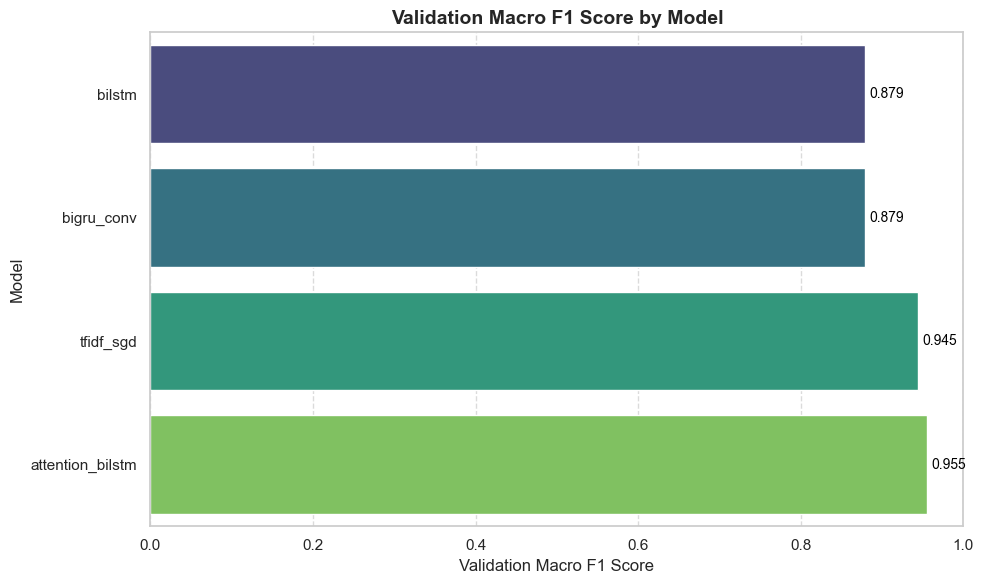

In [38]:
# Plot showing validation macro_f1 scores across all models (improved bar chart)
results_df = pd.DataFrame(MODEL_RESULTS)

MODEL_COMPARISON_METRICS_PATH = REPORTS_DIR / 'model_comparison_metrics.png'

if not results_df.empty:
    # Sort by macro F1 for better visualization
    results_df = results_df.sort_values('val_macro_f1', ascending=True).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = sns.barplot(data=results_df, x='val_macro_f1', y='model', palette='viridis', ax=ax, orient='h')
    
    # Add value labels on bars
    for bar in bars.patches:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', 
                ha='left', va='center', fontsize=10, color='black')
    
    ax.set_title('Validation Macro F1 Score by Model', fontsize=14, fontweight='bold')
    ax.set_xlabel('Validation Macro F1 Score', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(MODEL_COMPARISON_METRICS_PATH, dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No model metrics available; ensure evaluation stages ran successfully.')

Very happy with these results. Can confidently say I made a model that beat a default scikit-learn gradient method. TFIDF + SGDClassifier was however, significantly faster with around 60 times shorter training time. 

### Model Comparison & Final Recommendation

In [ ]:
# Compile all model results into a DataFrame, sort by macro-F1, and save to CSV

if not results_df.empty:
    results_df = results_df.sort_values('val_macro_f1', ascending=False).reset_index(drop=True)
    results_path = METRICS_DIR / 'model_comparison.csv'
    results_df.to_csv(results_path, index=False)
    print('Validation metrics summary:')
    display(results_df)
    best_model_name = results_df.iloc[0]['model']
    print(f"Recommended model based on macro-F1: {best_model_name}")
    print(f"Model comparison table saved -> {results_path}")
else:
    print('No model metrics available; ensure evaluation stages ran successfully.')


Validation metrics summary:


,model,val_accuracy,val_macro_f1,val_macro_recall,val_macro_precision,val_top3_accuracy,val_roc_auc_macro,train_accuracy,best_val_macro_f1
0,attention_bilstm,0.965723,0.955144,0.954724,0.956676,0.988264,0.998956,NaN,NaN
1,tfidf_sgd,0.953987,0.944729,0.951442,0.942688,0.978763,0.995923,0.975316,NaN
2,bigru_conv,0.908346,0.879495,0.874468,0.889109,0.967586,0.996065,NaN,NaN
3,bilstm,0.909836,0.878835,0.867798,0.895057,0.972057,0.997458,NaN,0.878835


Recommended model based on macro-F1: attention_bilstm
Model comparison table saved -> reports\metrics\model_comparison.csv


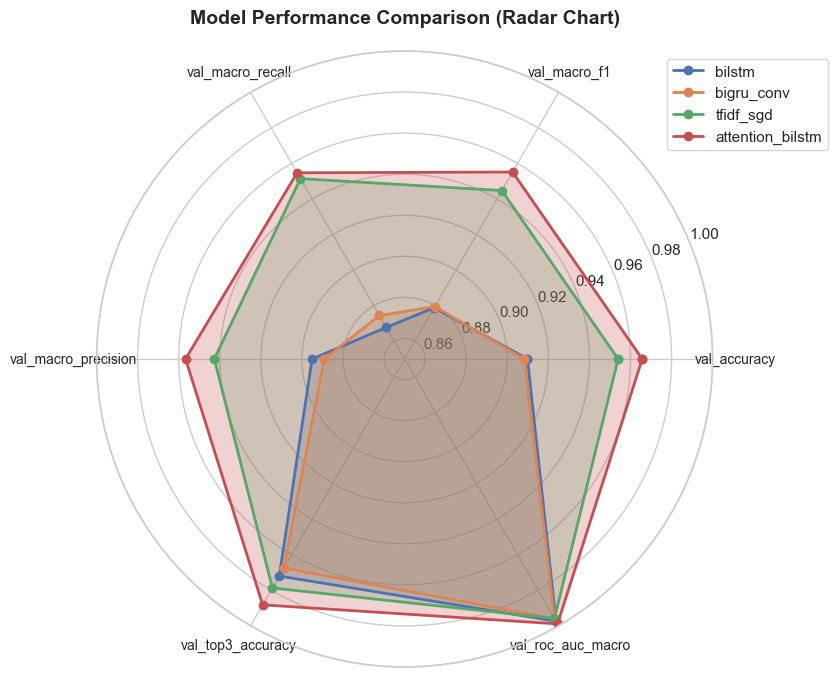

In [42]:
# Radar chart comparing all models across multiple metrics

from math import pi

RADAR_CHART_PATH = REPORTS_DIR / 'model_comparison_radar.png'

if not results_df.empty:
    metrics = [
        'val_accuracy',
        'val_macro_f1',
        'val_macro_recall',
        'val_macro_precision',
        'val_top3_accuracy',
        'val_roc_auc_macro'
    ]

    models = results_df['model'].tolist()
    values = results_df[metrics].values

    # Use raw values (already 0-1 scale) - removed normalization
    values_for_plot = values  

    # Radar chart setup
    num_vars = len(metrics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    for i, model in enumerate(models):
        values_model = np.concatenate([values_for_plot[i], [values_for_plot[i][0]]])  # Complete the loop
        ax.plot(angles, values_model, 'o-', linewidth=2, label=model)
        ax.fill(angles, values_model, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=10)
    ax.set_ylim(0.85, 1)  # Keep 0-1 scale since metrics are probabilities/ratios
    ax.set_title('Model Performance Comparison (Radar Chart)', size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)

    plt.savefig(RADAR_CHART_PATH, dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No model metrics available; ensure evaluation stages ran successfully.')

**Final Thoughts**

Neural nets are clearly quite good at separating authors in a 45-way classification task. This dataset was quite imbalanced but despite that, decent feature engineering that allowed the models to pick up on author nuance using n-grams a good outcome was achieved. The EDA itself may not have shown much outside of the Chi-Square feature selection but understanding the data and what each record contained did help in designing effective functions to separate noise from valuable text.

The final model presented is the Attention variant of the Bidirectional Long-term Short-Term Recurrent Neural Network. It achieved the highest macro-f1 of 0.955, an accuracy of 0.966. Any of the models trained would be acceptable in use for the bot. If accuracy is the primary concern: use attention_bilstm for guessing Victorian Era Authors. If training time and inference is the primary concern: tfidf_sgd performs well.

The one drawback of the models presented is the same of any static dataset trained model. These models will only be able to predict for authors present in the dataset, other Victorian Era authors that were not present will likely lead to incorrect classifications.

## Reference List

Amor, A., Liu, L., Westermann, M. and Xiao, Y., 2025. scikit-learn. [online] Available at: <https://scikit-learn.org/stable/about.html#the-people-behind-scikit-learn> [Accessed 2 October 2025].  

Apache, 2025. PySpark API Reference. [online] Available at: <https://spark.apache.org/docs/latest/api/python/reference/index.html> [Accessed 2 October 2025].  

Google Brain, 2025. API Documentation. [online] Available at: <https://www.tensorflow.org/api_docs> [Accessed 2 October 2025].  

Gungor, A., 2018. Fifty Victorian Era Novelists Authorship Attribution Data. [online] Available at: <https://archive.ics.uci.edu/dataset/454/victorian+era+authorship+attribution> [Accessed 2 October 2025].  

Hunter, J., Dale, D., Firing, E., Droettboom, M. and Matplotlib development team, 2025. Using Matplotlib. [online] Available at: <https://matplotlib.org/stable/users/index.html> [Accessed 2 October 2025].  

Joblib Developers, 2021. Joblib: running Python functions as pipeline jobs. [online] Available at: <https://joblib.readthedocs.io/en/stable/> [Accessed 2 October 2025].  

Numpy Developers, 2025. NumPy documentation. [online] Available at: <https://numpy.org/devdocs/> [Accessed 2 October 2025].  

Pandas, 2025. User Guide. [online] Available at: <https://pandas.pydata.org/docs/user_guide/style.html> [Accessed 2 October 2025].  

Waskom, M., 2024. An introduction to seaborn. [online] Available at: <https://seaborn.pydata.org/tutorial/introduction.html> [Accessed 2 October 2025].
 
